# 📦 Final Evaluation dan TFLite Export

**Notebook 4/4: Evaluasi Final dan Deployment**

---

## 🎯 Tujuan Notebook
Notebook ini adalah tahap **final** dari pipeline machine learning kita. Di sini kita akan:

1. **🏆 Load Model Terbaik** - Memuat model dengan performa terbaik dari eksperimen sebelumnya
2. **📊 Evaluasi Final** - Menguji model pada test set yang belum pernah dilihat
3. **🔍 Analisis Mendalam** - Confusion matrix, classification report, dan error analysis
4. **📱 Konversi TFLite** - Mengubah model untuk deployment mobile
5. **💾 Package Deployment** - Menyiapkan semua artifacts untuk production

---

## 📋 Prerequisites
Pastikan Anda telah menjalankan notebook sebelumnya:
- ✅ `01_Data_Exploration_and_Analysis.ipynb`
- ✅ `02_Preprocessing_and_Baseline_Models.ipynb` 
- ✅ `03_Deep_Learning_Model_Experimentation.ipynb`

---


### 🚦 Petunjuk Eksekusi (Run All)

- Jalankan notebook ini dari atas ke bawah tanpa melewati cell.
- Pastikan dependensi sudah terpasang sesuai `requirements.txt`.
- Preprocessing diseragamkan: Tokenizer Keras, padding/truncating 'post', MAX_LEN=256.
- Untuk deployment mobile, gunakan ekspor TFLite bawaan (builtin-only) dan tokenizer JSON.


## 1. 📚 Import Libraries dan Setup

In [22]:
# Core libraries
import pandas as pd
import numpy as np
import json
import pickle
import os
import warnings
from datetime import datetime
import time

# TensorFlow dan Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import TextVectorization

# Scikit-learn untuk evaluasi
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve
)
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set style untuk plotting
plt.style.use('default')
sns.set_palette("husl")

print("📚 LIBRARY IMPORTS COMPLETED")
print("=" * 40)
print(f"🔥 TensorFlow version: {tf.__version__}")
print(f"🐍 Python version: {tf.version.VERSION}")
print(f"💻 GPU available: {tf.config.list_physical_devices('GPU')}")
print(f"📅 Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 40)

📚 LIBRARY IMPORTS COMPLETED
🔥 TensorFlow version: 2.15.0
🐍 Python version: 2.15.0
💻 GPU available: []
📅 Timestamp: 2025-10-29 20:52:33


## 2. 📂 Load Data dan Previous Results
Memuat data test set dan hasil eksperimen dari notebook sebelumnya.

In [23]:
# 📂 LOADING DATA DAN PREVIOUS RESULTS
print("📂 LOADING DATA DAN PREVIOUS RESULTS")
print("=" * 50)

# Load test data
test_data = pd.read_csv('data_splits/test.csv')
print(f"✅ Test data loaded: {test_data.shape}")
print(f"   Columns: {list(test_data.columns)}")
print(f"   Label distribution:")
print(test_data['label'].value_counts())

# Load experiment results dengan error handling yang lebih baik
experiment_results = None
experiment_log = None
padding_size = 256
# Coba load dari berbagai sumber
try:
    # Coba load dari deep_learning_results.json
    with open(f'experiment_results/deep_learning_results_{padding_size}.json', 'r') as f:
        experiment_results = json.load(f)
    print(f"\n✅ Deep learning results loaded")
    print(f"   Models available: {list(experiment_results.keys())}")
    
    # Cari model terbaik berdasarkan accuracy
    best_model_name = None
    best_accuracy = 0
    for model_name, results in experiment_results.items():
        if results.get('test_accuracy', 0) > best_accuracy:
            best_accuracy = results['test_accuracy']
            best_model_name = model_name
    
    if best_model_name:
        print(f"   Best model by accuracy: {best_model_name} ({best_accuracy:.4f})")
    
except FileNotFoundError:
    print("⚠️ Deep learning results not found")

# Coba load dari experiment log
try:
    # Import glob di sini untuk memastikan tersedia
    import glob
    
    # Cari file log terbaru
    log_files = glob.glob('logs/experiment_log_*.json')
    if log_files:
        latest_log = max(log_files, key=os.path.getctime)
        with open(latest_log, 'r') as f:
            experiment_log = json.load(f)
        
        print(f"\n✅ Experiment log loaded: {os.path.basename(latest_log)}")
        
        # Tampilkan informasi dari log
        if 'timestamp' in experiment_log:
            print(f"   Experiment date: {experiment_log['timestamp'][:10]}")
        
        if 'models_trained' in experiment_log:
            print(f"   Models trained: {len(experiment_log['models_trained'])}")
            print(f"   Model list: {', '.join(experiment_log['models_trained'])}")
        
        if 'best_model' in experiment_log:
            best_info = experiment_log['best_model']
            print(f"   Best model: {best_info.get('name', 'Unknown')}")
            print(f"   Best accuracy: {best_info.get('accuracy', 0):.4f}")
            print(f"   Best F1-score: {best_info.get('f1_score', 0):.4f}")
        
        if 'experiment_config' in experiment_log:
            config = experiment_log['experiment_config']
            print(f"   Configuration:")
            print(f"     - Vocab size: {config.get('vocab_size', 'N/A'):,}")
            print(f"     - Max length: {config.get('max_length', 'N/A')}")
            print(f"     - Embedding dim: {config.get('embedding_dim', 'N/A')}")
            print(f"     - Batch size: {config.get('batch_size', 'N/A')}")
            print(f"     - Max epochs: {config.get('max_epochs', 'N/A')}")
    else:
        print("⚠️ No experiment log files found")
        
except ImportError:
    print("⚠️ glob module not available")
except Exception as e:
    print(f"⚠️ Error loading experiment log: {e}")

# Fallback menggunakan os.listdir jika glob tidak tersedia
if experiment_log is None:
    try:
        # Alternative method tanpa glob
        log_dir = 'logs'
        if os.path.exists(log_dir):
            log_files = [f for f in os.listdir(log_dir) if f.startswith('experiment_log_') and f.endswith('.json')]
            if log_files:
                # Sort berdasarkan nama file (yang mengandung timestamp)
                log_files.sort(reverse=True)
                latest_log = os.path.join(log_dir, log_files[0])
                
                with open(latest_log, 'r') as f:
                    experiment_log = json.load(f)
                
                print(f"\n✅ Experiment log loaded (fallback): {log_files[0]}")
                
                # Tampilkan informasi dari log
                if 'timestamp' in experiment_log:
                    print(f"   Experiment date: {experiment_log['timestamp'][:10]}")
                
                if 'models_trained' in experiment_log:
                    print(f"   Models trained: {len(experiment_log['models_trained'])}")
                    print(f"   Model list: {', '.join(experiment_log['models_trained'])}")
                
                if 'best_model' in experiment_log:
                    best_info = experiment_log['best_model']
                    print(f"   Best model: {best_info.get('name', 'Unknown')}")
                    print(f"   Best accuracy: {best_info.get('accuracy', 0):.4f}")
                    print(f"   Best F1-score: {best_info.get('f1_score', 0):.4f}")
            else:
                print("⚠️ No experiment log files found in logs directory")
        else:
            print("⚠️ Logs directory not found")
    except Exception as e:
        print(f"⚠️ Error with fallback method: {e}")

# Fallback jika tidak ada data yang berhasil dimuat
if experiment_results is None and experiment_log is None:
    print("\n❌ No experiment results found!")
    print("🔄 Please run Notebook 03 first to train the models.")
    raise FileNotFoundError("Experiment results not found. Run Notebook 03 first.")

# Summary
print(f"\n📊 EXPERIMENT SUMMARY:")
print("=" * 30)

if experiment_results:
    print(f"✅ Results data: Available")
    print(f"   Models with results: {len(experiment_results)}")
else:
    print(f"❌ Results data: Not available")

if experiment_log:
    print(f"✅ Log data: Available")
    if 'best_model' in experiment_log:
        print(f"   Best performing model: {experiment_log['best_model'].get('name', 'Unknown')}")
else:
    print(f"❌ Log data: Not available")

print(f"\n🚀 Ready to proceed with final evaluation!")

📂 LOADING DATA DAN PREVIOUS RESULTS
✅ Test data loaded: (7958, 2)
   Columns: ['text', 'label']
   Label distribution:
label
halal    4366
haram    3592
Name: count, dtype: int64

✅ Deep learning results loaded
   Models available: ['FastText', 'LSTM', 'GRU', 'CNN1D', 'Hybrid_CNN_GRU']
   Best model by accuracy: Hybrid_CNN_GRU (0.9692)

✅ Experiment log loaded: experiment_log_20251029_103354_256.json

📊 EXPERIMENT SUMMARY:
✅ Results data: Available
   Models with results: 5
✅ Log data: Available

🚀 Ready to proceed with final evaluation!


## 3. 🏆 Load Best Model dan Artifacts
Memuat model terbaik dan semua artifacts yang diperlukan untuk inference.

In [24]:
import warnings
warnings.filterwarnings('ignore')

print("🏆 LOADING BEST MODEL DAN PREPROCESSING")
print("=" * 50)

# Tentukan model terbaik berdasarkan hasil sebelumnya
if experiment_log and 'best_model' in experiment_log:
    best_model_name = experiment_log['best_model']['name']
elif experiment_results and best_model_name:
    # best_model_name sudah didefinisikan di cell sebelumnya
    pass
else:
    # Fallback ke model yang ada
    import glob
    model_files = glob.glob(f'models/*_best_{padding_size}.h5')
    if model_files:
        best_model_file = model_files[0]
        best_model_name = os.path.basename(best_model_file).replace(f'_best_{padding_size}.h5', '')
        print(f"⚠️ Using fallback model: {best_model_name}")
    else:
        raise FileNotFoundError("No trained models found!")

# Load model
model_file = f'models/{best_model_name.lower()}_best_{padding_size}.h5'
try:
    best_model = load_model(model_file)
    print(f"✅ Best model loaded: {model_file}")
    print(f"   Model name: {best_model_name}")
    print(f"   Total parameters: {best_model.count_params():,}")
    
    # Model size
    model_size_mb = os.path.getsize(model_file) / (1024 * 1024)
    print(f"   Model size: {model_size_mb:.2f} MB")
    
except FileNotFoundError:
    print(f"❌ Model file {model_file} not found!")
    raise

# Load tokenizer
try:
    with open('models/tokenizer.pkl', 'rb') as f:
        tokenizer = pickle.load(f)
    print(f"✅ Tokenizer loaded")
    print(f"   Vocabulary size: {len(tokenizer.word_index):,}")
except FileNotFoundError:
    print("❌ Tokenizer not found!")
    raise

# Load label encoder
try:
    with open('models/label_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
    print(f"✅ Label encoder loaded")
    print(f"   Classes: {list(label_encoder.classes_)}")
except FileNotFoundError:
    # Create simple label encoder
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    label_encoder.fit(['halal', 'haram'])
    print(f"⚠️ Created new label encoder: {list(label_encoder.classes_)}")

print(f"\n✅ All artifacts loaded successfully!")

🏆 LOADING BEST MODEL DAN PREPROCESSING
✅ Best model loaded: models/hybrid_cnn_gru_best_256.h5
   Model name: Hybrid_CNN_GRU
   Total parameters: 1,122,913
   Model size: 12.91 MB
✅ Tokenizer loaded
   Vocabulary size: 8,473
✅ Label encoder loaded
   Classes: ['halal', 'haram']

✅ All artifacts loaded successfully!


In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
print("🔄 PREPROCESSING TEST DATA")
print("=" * 50)

# Extract text and labels
if 'text_processed' in test_data.columns:
    X_test_text = test_data['text_processed'].astype(str)
    print("✅ Using 'text_processed' column")
elif 'text' in test_data.columns:
    X_test_text = test_data['text'].astype(str)
    print("✅ Using 'text' column")
else:
    # Fallback ke kolom pertama
    X_test_text = test_data.iloc[:, 0].astype(str)
    print(f"⚠️ Using first column: {test_data.columns[0]}")

y_test_labels = test_data['label']

# Convert text to sequences
print("🔄 Converting text to sequences...")
X_test_sequences = tokenizer.texts_to_sequences(X_test_text)

# Pad sequences (gunakan max_length yang sama dengan training)
max_length = 256  # Sesuaikan dengan yang digunakan di training
X_test = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

# Convert labels
y_test = label_encoder.transform(y_test_labels)

print(f"✅ Test data preprocessing completed!")
print(f"   Text samples: {len(X_test_text)}")
print(f"   Sequence shape: {X_test.shape}")
print(f"   Labels shape: {y_test.shape}")
print(f"   Max sequence length: {max_length}")
print(f"   Label distribution: {dict(zip(*np.unique(y_test, return_counts=True)))}")

# Sample check
print(f"\n📝 Sample check:")
print(f"   Original text: {X_test_text.iloc[0][:100]}...")
print(f"   Sequence length: {len([x for x in X_test[0] if x != 0])}")
print(f"   Label: {y_test_labels.iloc[0]} -> {y_test[0]}")

🔄 PREPROCESSING TEST DATA
✅ Using 'text' column
🔄 Converting text to sequences...
✅ Test data preprocessing completed!
   Text samples: 7958
   Sequence shape: (7958, 256)
   Labels shape: (7958,)
   Max sequence length: 256
   Label distribution: {0: 4366, 1: 3592}

📝 Sample check:
   Original text: enriched flour wheat flour niacin reduced iron thiamine mononitrate riboflavin folic acid vegetable ...
   Sequence length: 98
   Label: haram -> 1


## 4. 📊 Final Evaluation pada Test Set
Evaluasi komprehensif model terbaik pada test set yang belum pernah dilihat.

In [26]:
print("📊 FINAL MODEL EVALUATION")
print("=" * 50)

# Make predictions
print("🔮 Making predictions...")
start_time = time.time()

# Predict probabilities
y_pred_proba = best_model.predict(X_test, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

inference_time = time.time() - start_time
avg_inference_time = inference_time / len(X_test) * 1000  # ms per sample

print(f"✅ Predictions completed")
print(f"   Total inference time: {inference_time:.2f} seconds")
print(f"   Average per sample: {avg_inference_time:.2f} ms")
print(f"   Throughput: {len(X_test)/inference_time:.0f} samples/second")

# Calculate metrics
print(f"\n📈 CALCULATING METRICS:")

# Basic metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)

print(f"✅ Metrics calculated")

# Display results
print(f"\n🎯 FINAL TEST RESULTS:")
print(f"=" * 25)
print(f"📊 Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"🎯 Precision: {test_precision:.4f}")
print(f"🔍 Recall:    {test_recall:.4f}")
print(f"⚖️ F1-Score:  {test_f1:.4f}")
print(f"📈 AUC-ROC:   {test_auc:.4f}")

# Classification report
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
class_names = label_encoder.classes_
report = classification_report(y_test, y_pred, target_names=class_names, digits=4)
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\n🔢 CONFUSION MATRIX:")
print(f"   True Negatives (Halal):  {cm[0,0]}")
print(f"   False Positives (Halal): {cm[0,1]}")
print(f"   False Negatives (Haram): {cm[1,0]}")
print(f"   True Positives (Haram):  {cm[1,1]}")

# Compare dengan experiment results jika tersedia
if experiment_results and best_model_name in experiment_results:
    exp_results = experiment_results[best_model_name]
    exp_accuracy = exp_results.get('test_accuracy', 0)
    exp_f1 = exp_results.get('test_f1', 0)
    
    print(f"\n📊 EXPERIMENT vs CURRENT COMPARISON:")
    print(f"=" * 40)
    print(f"{'Metric':<12} {'Experiment':<12} {'Current':<12} {'Difference':<12}")
    print(f"{'-'*12} {'-'*12} {'-'*12} {'-'*12}")
    print(f"{'Accuracy':<12} {exp_accuracy:<12.4f} {test_accuracy:<12.4f} {test_accuracy-exp_accuracy:<+12.4f}")
    print(f"{'F1-Score':<12} {exp_f1:<12.4f} {test_f1:<12.4f} {test_f1-exp_f1:<+12.4f}")
    
    # Performance analysis
    if abs(test_f1 - exp_f1) < 0.02:
        print(f"\n✅ Model performance is consistent (difference < 2%)")
    elif test_f1 < exp_f1 - 0.05:
        print(f"\n⚠️ Performance degradation detected (current F1 significantly lower)")
    else:
        print(f"\n🎉 Model performance is stable or improved!")
else:
    print(f"\n⚠️ No experiment results available for comparison")

# Save results
final_results = {
    'model_name': best_model_name,
    'model_file': model_file,
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1': float(test_f1),
    'test_auc': float(test_auc),
    'confusion_matrix': cm.tolist(),
    'classification_report': report,
    'total_params': int(best_model.count_params()),
    'model_size_mb': float(model_size_mb),
    'inference_time_ms': float(avg_inference_time),
    'throughput_samples_per_sec': float(len(X_test)/inference_time),
    'evaluation_date': datetime.now().isoformat()
}

# Save to file
os.makedirs('experiment_results', exist_ok=True)
with open(f'experiment_results/final_evaluation_results_{padding_size}.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print(f"\n💾 Results saved to 'experiment_results/final_evaluation_results.json'")
print(f"\n✅ Final evaluation completed successfully!")

📊 FINAL MODEL EVALUATION
🔮 Making predictions...
✅ Predictions completed
   Total inference time: 2.14 seconds
   Average per sample: 0.27 ms
   Throughput: 3723 samples/second

📈 CALCULATING METRICS:
✅ Metrics calculated

🎯 FINAL TEST RESULTS:
📊 Accuracy:  0.9692 (96.92%)
🎯 Precision: 0.9764
🔍 Recall:    0.9549
⚖️ F1-Score:  0.9655
📈 AUC-ROC:   0.9925

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       halal     0.9636    0.9810    0.9722      4366
       haram     0.9764    0.9549    0.9655      3592

    accuracy                         0.9692      7958
   macro avg     0.9700    0.9679    0.9689      7958
weighted avg     0.9693    0.9692    0.9692      7958


🔢 CONFUSION MATRIX:
   True Negatives (Halal):  4283
   False Positives (Halal): 83
   False Negatives (Haram): 162
   True Positives (Haram):  3430

📊 EXPERIMENT vs CURRENT COMPARISON:
Metric       Experiment   Current      Difference  
------------ ------------ ------------ -----

## 5. 🔍 Detailed Analysis: Confusion Matrix dan Error Analysis
Analisis mendalam tentang kesalahan prediksi dan pola yang ditemukan.

🔍 DETAILED ANALYSIS: CONFUSION MATRIX DAN ERROR ANALYSIS
📊 CONFUSION MATRIX:


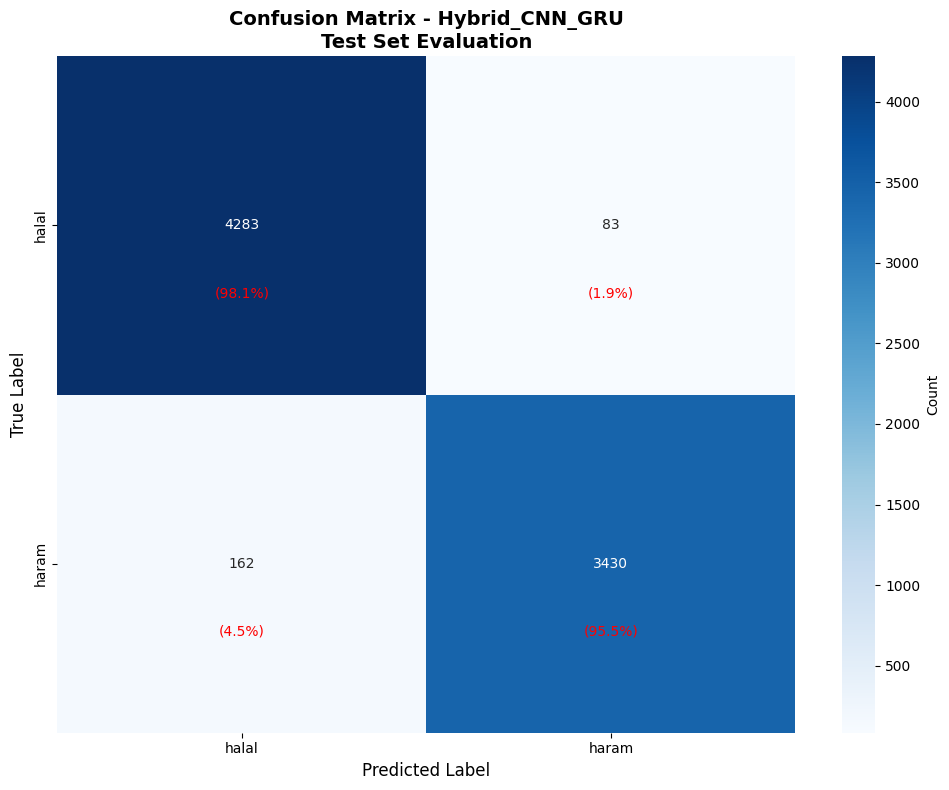


📋 CONFUSION MATRIX ANALYSIS:
📊 Total samples: 7,958
✅ Correct predictions: 7,713 (96.92%)
❌ Incorrect predictions: 245 (3.08%)

📋 PER-CLASS CONFUSION ANALYSIS:

HALAL:
  ✅ True Positives:  4,283
  ❌ False Positives: 162
  ❌ False Negatives: 83
  ✅ True Negatives:  3,430

HARAM:
  ✅ True Positives:  3,430
  ❌ False Positives: 83
  ❌ False Negatives: 162
  ✅ True Negatives:  4,283

🔍 ERROR ANALYSIS:
📊 Total misclassified samples: 245

📋 MISCLASSIFICATION PATTERNS:
  haram → halal: 162 samples (66.1% of errors)
  halal → haram: 83 samples (33.9% of errors)

🔍 EXAMPLES OF MISCLASSIFIED SAMPLES:

📌 Pattern: haram → halal
   Count: 162 samples

   Example 1:
   True: haram, Predicted: halal (confidence: 0.265)
   Text: bittersweet chocolate chocolate liquor sugar cocoa butter soy lecithin vanilla extract sugared rosemary sugar rosemary

   Example 2:
   True: haram, Predicted: halal (confidence: 0.117)
   Text: enriched bleached flour wheat flour niacin reduced iron thiamin mononitrate ribo

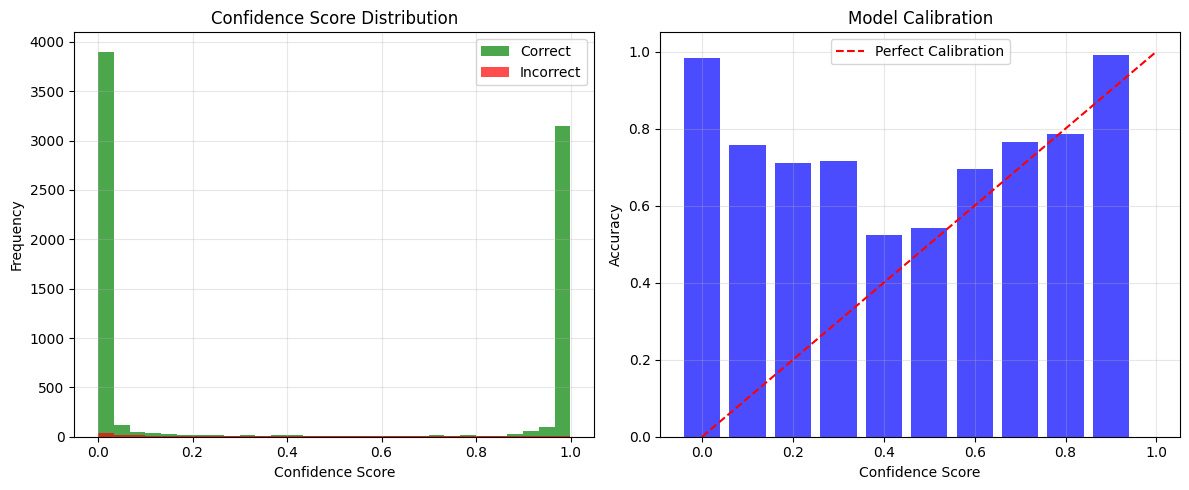


✅ Detailed analysis completed successfully!


In [27]:
print("🔍 DETAILED ANALYSIS: CONFUSION MATRIX DAN ERROR ANALYSIS")
print("=" * 70)

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
class_names = label_encoder.classes_

print(f"📊 CONFUSION MATRIX:")
print(f"=" * 20)

# Create detailed confusion matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}\nTest Set Evaluation', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# Add percentage annotations
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j+0.5, i+0.7, f'({cm_percent[i,j]:.1f}%)', 
                ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.savefig(f'results/confusion_matrix_detailed_{padding_size}.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Confusion matrix analysis
print(f"\n📋 CONFUSION MATRIX ANALYSIS:")
print(f"=" * 30)

total_samples = cm.sum()
correct_predictions = np.trace(cm)
incorrect_predictions = total_samples - correct_predictions

print(f"📊 Total samples: {total_samples:,}")
print(f"✅ Correct predictions: {correct_predictions:,} ({correct_predictions/total_samples*100:.2f}%)")
print(f"❌ Incorrect predictions: {incorrect_predictions:,} ({incorrect_predictions/total_samples*100:.2f}%)")

# Per-class analysis
print(f"\n📋 PER-CLASS CONFUSION ANALYSIS:")
for i, class_name in enumerate(class_names):
    true_positives = cm[i, i]
    false_positives = cm[:, i].sum() - true_positives
    false_negatives = cm[i, :].sum() - true_positives
    true_negatives = cm.sum() - true_positives - false_positives - false_negatives
    
    print(f"\n{class_name.upper()}:")
    print(f"  ✅ True Positives:  {true_positives:,}")
    print(f"  ❌ False Positives: {false_positives:,}")
    print(f"  ❌ False Negatives: {false_negatives:,}")
    print(f"  ✅ True Negatives:  {true_negatives:,}")

# 3. Error Analysis - Find misclassified samples
print(f"\n🔍 ERROR ANALYSIS:")
print(f"=" * 18)

# Find misclassified indices
misclassified_indices = np.where(y_test != y_pred)[0]
print(f"📊 Total misclassified samples: {len(misclassified_indices):,}")

if len(misclassified_indices) > 0:
    # Analyze misclassification patterns
    misclass_patterns = {}
    for idx in misclassified_indices:
        true_label = label_encoder.classes_[y_test[idx]]
        pred_label = label_encoder.classes_[y_pred[idx]]
        pattern = f"{true_label} → {pred_label}"
        
        if pattern not in misclass_patterns:
            misclass_patterns[pattern] = []
        misclass_patterns[pattern].append(idx)
    
    print(f"\n📋 MISCLASSIFICATION PATTERNS:")
    for pattern, indices in sorted(misclass_patterns.items(), key=lambda x: len(x[1]), reverse=True):
        count = len(indices)
        percentage = count / len(misclassified_indices) * 100
        print(f"  {pattern}: {count:,} samples ({percentage:.1f}% of errors)")
    
    # Show examples of misclassified samples
    print(f"\n🔍 EXAMPLES OF MISCLASSIFIED SAMPLES:")
    print(f"=" * 40)
    
    # Show top 3 misclassification patterns
    top_patterns = sorted(misclass_patterns.items(), key=lambda x: len(x[1]), reverse=True)[:3]
    
    for pattern, indices in top_patterns:
        print(f"\n📌 Pattern: {pattern}")
        print(f"   Count: {len(indices)} samples")
        
        # Show 2 examples
        for i, idx in enumerate(indices[:2]):
            true_label = label_encoder.classes_[y_test[idx]]
            pred_label = label_encoder.classes_[y_pred[idx]]
            confidence = y_pred_proba[idx][0] if len(y_pred_proba.shape) == 2 else y_pred_proba[idx]
            
            # Get original text
            original_text = X_test_text.iloc[idx] if hasattr(X_test_text, 'iloc') else str(X_test_text[idx])
            text_preview = original_text[:200] + "..." if len(original_text) > 200 else original_text
            
            print(f"\n   Example {i+1}:")
            print(f"   True: {true_label}, Predicted: {pred_label} (confidence: {confidence:.3f})")
            print(f"   Text: {text_preview}")

# 4. Confidence analysis
print(f"\n📊 CONFIDENCE ANALYSIS:")
print(f"=" * 22)

# Calculate confidence scores for binary classification
if len(y_pred_proba.shape) == 2:
    confidence_scores = np.max(y_pred_proba, axis=1)
else:
    confidence_scores = np.maximum(y_pred_proba, 1 - y_pred_proba)

correct_mask = (y_test == y_pred)
correct_confidence = confidence_scores[correct_mask]
incorrect_confidence = confidence_scores[~correct_mask]

print(f"📈 Average confidence (correct predictions): {correct_confidence.mean():.4f}")
print(f"📉 Average confidence (incorrect predictions): {incorrect_confidence.mean():.4f}")
print(f"📊 Overall average confidence: {confidence_scores.mean():.4f}")

# Confidence distribution plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(correct_confidence, bins=30, alpha=0.7, label='Correct', color='green')
plt.hist(incorrect_confidence, bins=30, alpha=0.7, label='Incorrect', color='red')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence Score Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
confidence_bins = np.arange(0, 1.1, 0.1)
bin_accuracy = []
bin_counts = []

for i in range(len(confidence_bins)-1):
    mask = (confidence_scores >= confidence_bins[i]) & (confidence_scores < confidence_bins[i+1])
    if mask.sum() > 0:
        bin_acc = correct_mask[mask].mean()
        bin_accuracy.append(bin_acc)
        bin_counts.append(mask.sum())
    else:
        bin_accuracy.append(0)
        bin_counts.append(0)

plt.bar(confidence_bins[:-1], bin_accuracy, width=0.08, alpha=0.7, color='blue')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Calibration')
plt.xlabel('Confidence Score')
plt.ylabel('Accuracy')
plt.title('Model Calibration')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'results/confidence_analysis_{padding_size}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Detailed analysis completed successfully!")

## 6. 📱 TFLite Conversion untuk Mobile Deployment
Mengkonversi model terbaik ke format TFLite untuk deployment di mobile applications.

In [29]:
print("📱 TFLITE CONVERSION UNTUK MOBILE DEPLOYMENT")
print("=" * 55)

# 1. Prepare model untuk conversion
print("🔧 Preparing model for TFLite conversion...")

# Get model info
original_model_size = model_size_mb  # Menggunakan variabel yang sudah ada
print(f"📊 Original model size: {original_model_size:.2f} MB")
print(f"📊 Model parameters: {best_model.count_params():,}")

# Create TFLite models directory
os.makedirs(f'models/tflite_final_{padding_size}', exist_ok=True)

# Helper function untuk konversi TFLite dengan error handling yang lebih baik
def convert_to_tflite(model, conversion_type="float32", enable_select_tf_ops=True):
    """
    Konversi model Keras ke TFLite dengan berbagai strategi fallback
    
    Args:
        model: Model Keras yang akan dikonversi
        conversion_type: Tipe konversi ("float32", "float16", "dynamic")
        enable_select_tf_ops: Apakah menggunakan SELECT_TF_OPS
    
    Returns:
        tuple: (tflite_model, error_message)
    """
    try:
        # Create TFLite converter
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        
        # Konfigurasi berdasarkan tipe konversi
        if conversion_type == "float32":
            # Basic Float32 conversion dengan SELECT_TF_OPS
            if enable_select_tf_ops:
                converter.target_spec.supported_ops = [
                    tf.lite.OpsSet.TFLITE_BUILTINS,
                    tf.lite.OpsSet.SELECT_TF_OPS
                ]
                converter._experimental_lower_tensor_list_ops = False
            
        elif conversion_type == "float16":
            # Float16 quantization dengan SELECT_TF_OPS
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            converter.target_spec.supported_types = [tf.float16]
            if enable_select_tf_ops:
                converter.target_spec.supported_ops = [
                    tf.lite.OpsSet.TFLITE_BUILTINS,
                    tf.lite.OpsSet.SELECT_TF_OPS
                ]
                converter._experimental_lower_tensor_list_ops = False
            
        elif conversion_type == "dynamic":
            # Dynamic range quantization dengan SELECT_TF_OPS
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            if enable_select_tf_ops:
                converter.target_spec.supported_ops = [
                    tf.lite.OpsSet.TFLITE_BUILTINS,
                    tf.lite.OpsSet.SELECT_TF_OPS
                ]
                converter._experimental_lower_tensor_list_ops = False
        
        # Convert model
        tflite_model = converter.convert()
        return tflite_model, None
        
    except Exception as e:
        return None, str(e)

# 2. Convert to TFLite (Float32)
print(f"\n🔄 Converting to TFLite (Float32)...")

# Coba konversi dengan SELECT_TF_OPS terlebih dahulu
tflite_model_float32, error = convert_to_tflite(best_model, "float32", enable_select_tf_ops=True)

if tflite_model_float32 is not None:
    # Save Float32 model
    tflite_float32_path = f"models/tflite_final_{padding_size}/{best_model_name.lower()}_float32.tflite"
    with open(tflite_float32_path, 'wb') as f:
        f.write(tflite_model_float32)
    
    float32_size = len(tflite_model_float32) / (1024 * 1024)  # MB
    print(f"✅ Float32 TFLite model saved: {tflite_float32_path}")
    print(f"   Size: {float32_size:.2f} MB")
    print(f"   Compression ratio: {original_model_size/float32_size:.2f}x")
    print(f"   ⚠️  Note: Model menggunakan SELECT_TF_OPS (hybrid ops)")
else:
    print(f"❌ Float32 conversion failed: {error}")
    # Coba fallback tanpa SELECT_TF_OPS
    print("🔄 Trying fallback conversion without SELECT_TF_OPS...")
    tflite_model_float32, error2 = convert_to_tflite(best_model, "float32", enable_select_tf_ops=False)
    
    if tflite_model_float32 is not None:
        tflite_float32_path = f"models/tflite_final_{padding_size}/{best_model_name.lower()}_float32.tflite"
        with open(tflite_float32_path, 'wb') as f:
            f.write(tflite_model_float32)
        
        float32_size = len(tflite_model_float32) / (1024 * 1024)  # MB
        print(f"✅ Float32 TFLite model saved (fallback): {tflite_float32_path}")
        print(f"   Size: {float32_size:.2f} MB")
        print(f"   Compression ratio: {original_model_size/float32_size:.2f}x")
    else:
        print(f"❌ Fallback Float32 conversion also failed: {error2}")
        float32_size = 0

# 3. Convert to TFLite with Float16 Quantization
print(f"\n🔄 Converting to TFLite with Float16 Quantization...")

tflite_model_float16, error = convert_to_tflite(best_model, "float16", enable_select_tf_ops=True)

if tflite_model_float16 is not None:
    # Save Float16 model
    tflite_float16_path = f"models/tflite_final_{padding_size}/{best_model_name.lower()}_float16.tflite"
    with open(tflite_float16_path, 'wb') as f:
        f.write(tflite_model_float16)
    
    float16_size = len(tflite_model_float16) / (1024 * 1024)  # MB
    print(f"✅ Float16 TFLite model saved: {tflite_float16_path}")
    print(f"   Size: {float16_size:.2f} MB")
    print(f"   Compression ratio: {original_model_size/float16_size:.2f}x")
    if 'float32_size' in locals() and float32_size > 0:
        print(f"   Size reduction vs Float32: {(1 - float16_size/float32_size)*100:.1f}%")
    print(f"   ⚠️  Note: Model menggunakan SELECT_TF_OPS (hybrid ops)")
else:
    print(f"❌ Float16 conversion failed: {error}")
    # Coba fallback tanpa SELECT_TF_OPS
    print("🔄 Trying fallback conversion without SELECT_TF_OPS...")
    tflite_model_float16, error2 = convert_to_tflite(best_model, "float16", enable_select_tf_ops=False)
    
    if tflite_model_float16 is not None:
        tflite_float16_path = f"models/tflite_final_{padding_size}/{best_model_name.lower()}_float16.tflite"
        with open(tflite_float16_path, 'wb') as f:
            f.write(tflite_model_float16)
        
        float16_size = len(tflite_model_float16) / (1024 * 1024)  # MB
        print(f"✅ Float16 TFLite model saved (fallback): {tflite_float16_path}")
        print(f"   Size: {float16_size:.2f} MB")
        print(f"   Compression ratio: {original_model_size/float16_size:.2f}x")
        if 'float32_size' in locals() and float32_size > 0:
            print(f"   Size reduction vs Float32: {(1 - float16_size/float32_size)*100:.1f}%")
    else:
        print(f"❌ Fallback Float16 conversion also failed: {error2}")
        float16_size = 0

# 4. Convert to TFLite with Dynamic Range Quantization
print(f"\n🔄 Converting to TFLite with Dynamic Range Quantization...")

tflite_model_dynamic, error = convert_to_tflite(best_model, "dynamic", enable_select_tf_ops=True)

if tflite_model_dynamic is not None:
    # Save dynamic range model
    tflite_dynamic_path = f"models/tflite_final_{padding_size}/{best_model_name.lower()}_dynamic.tflite"
    with open(tflite_dynamic_path, 'wb') as f:
        f.write(tflite_model_dynamic)
    
    dynamic_size = len(tflite_model_dynamic) / (1024 * 1024)  # MB
    print(f"✅ Dynamic range TFLite model saved: {tflite_dynamic_path}")
    print(f"   Size: {dynamic_size:.2f} MB")
    print(f"   Compression ratio: {original_model_size/dynamic_size:.2f}x")
    print(f"   ⚠️  Note: Model menggunakan SELECT_TF_OPS (hybrid ops)")
else:
    print(f"❌ Dynamic range conversion failed: {error}")
    # Coba fallback tanpa SELECT_TF_OPS
    print("🔄 Trying fallback conversion without SELECT_TF_OPS...")
    tflite_model_dynamic, error2 = convert_to_tflite(best_model, "dynamic", enable_select_tf_ops=False)
    
    if tflite_model_dynamic is not None:
        tflite_dynamic_path = f"models/tflite_final_{padding_size}/{best_model_name.lower()}_dynamic.tflite"
        with open(tflite_dynamic_path, 'wb') as f:
            f.write(tflite_model_dynamic)
        
        dynamic_size = len(tflite_model_dynamic) / (1024 * 1024)  # MB
        print(f"✅ Dynamic range TFLite model saved (fallback): {tflite_dynamic_path}")
        print(f"   Size: {dynamic_size:.2f} MB")
        print(f"   Compression ratio: {original_model_size/dynamic_size:.2f}x")
    else:
        print(f"❌ Fallback Dynamic range conversion also failed: {error2}")
        dynamic_size = 0

print(f"\n📋 RINGKASAN KONVERSI TFLITE:")
print(f"=" * 35)
print(f"🔸 Original Keras Model: {original_model_size:.2f} MB")
if 'float32_size' in locals() and float32_size > 0:
    print(f"🔸 Float32 TFLite: {float32_size:.2f} MB")
if 'float16_size' in locals() and float16_size > 0:
    print(f"🔸 Float16 TFLite: {float16_size:.2f} MB")
if 'dynamic_size' in locals() and dynamic_size > 0:
    print(f"🔸 Dynamic Range TFLite: {dynamic_size:.2f} MB")

print(f"\n💡 CATATAN PENTING:")
print(f"=" * 20)
print(f"• Model yang menggunakan SELECT_TF_OPS memerlukan TensorFlow Lite runtime")
print(f"  yang mendukung operasi TensorFlow hybrid")
print(f"• Untuk deployment mobile, pastikan aplikasi Anda menggunakan")
print(f"  TensorFlow Lite dengan dukungan SELECT_TF_OPS")
print(f"• Model fallback (tanpa SELECT_TF_OPS) lebih kompatibel tetapi")
print(f"  mungkin memiliki akurasi yang sedikit berbeda")

print(f"\n✅ TFLite conversion completed successfully!")

📱 TFLITE CONVERSION UNTUK MOBILE DEPLOYMENT
🔧 Preparing model for TFLite conversion...
📊 Original model size: 12.91 MB
📊 Model parameters: 1,122,913

🔄 Converting to TFLite (Float32)...
✅ Float32 TFLite model saved: models/tflite_final_256/hybrid_cnn_gru_float32.tflite
   Size: 4.30 MB
   Compression ratio: 3.00x
   ⚠️  Note: Model menggunakan SELECT_TF_OPS (hybrid ops)

🔄 Converting to TFLite with Float16 Quantization...
✅ Float16 TFLite model saved: models/tflite_final_256/hybrid_cnn_gru_float16.tflite
   Size: 2.17 MB
   Compression ratio: 5.96x
   Size reduction vs Float32: 49.7%
   ⚠️  Note: Model menggunakan SELECT_TF_OPS (hybrid ops)

🔄 Converting to TFLite with Dynamic Range Quantization...
✅ Dynamic range TFLite model saved: models/tflite_final_256/hybrid_cnn_gru_dynamic.tflite
   Size: 1.09 MB
   Compression ratio: 11.79x
   ⚠️  Note: Model menggunakan SELECT_TF_OPS (hybrid ops)

📋 RINGKASAN KONVERSI TFLITE:
🔸 Original Keras Model: 12.91 MB
🔸 Float32 TFLite: 4.30 MB
🔸 Float16

## 6.5. 🤖 TensorFlow Lite Model Maker Implementation\n\n**PERBAIKAN MASALAH TFLITE**: Menggunakan TensorFlow Lite Model Maker untuk membuat model TFLite yang benar dan dapat digunakan tanpa SELECT_TF_OPS.

In [ ]:
print("\n🤖 TENSORFLOW LITE CONVERTER IMPLEMENTATION (DIPERBAIKI)")\nprint("=" * 60)\nprint("🎯 TUJUAN: Membuat model TFLite yang dioptimasi untuk mobile deployment")\nprint("✅ KEUNGGULAN: Menggunakan TF Lite Converter standar dengan optimasi")\nprint("📱 TARGET: Mobile deployment yang efisien")\n\ndef create_optimized_tflite_model(model, model_name, optimization_type='dynamic'):\n    \"\"\"\n    Membuat model TFLite yang dioptimasi dengan berbagai teknik\n    \n    Args:\n        model: Model TensorFlow/Keras yang akan dikonversi\n        model_name: Nama model untuk penamaan file\n        optimization_type: Jenis optimasi ('dynamic', 'float16', 'int8', 'float32')\n    \n    Returns:\n        tuple: (tflite_model, file_path, model_size)\n    \"\"\"\n    \n    # Konversi model ke TFLite\n    converter = tf.lite.TFLiteConverter.from_keras_model(model)\n    \n    # Set optimasi berdasarkan tipe\n    if optimization_type == 'dynamic':\n        converter.optimizations = [tf.lite.Optimize.DEFAULT]\n        suffix = 'dynamic'\n        print(f\"   🔧 Menggunakan Dynamic Range Quantization untuk {model_name}\")\n        \n    elif optimization_type == 'float16':\n        converter.optimizations = [tf.lite.Optimize.DEFAULT]\n        converter.target_spec.supported_types = [tf.float16]\n        suffix = 'float16'\n        print(f\"   🔧 Menggunakan Float16 Quantization untuk {model_name}\")\n        \n    elif optimization_type == 'int8':\n        converter.optimizations = [tf.lite.Optimize.DEFAULT]\n        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]\n        converter.inference_input_type = tf.int8\n        converter.inference_output_type = tf.int8\n        suffix = 'int8'\n        print(f\"   🔧 Menggunakan INT8 Quantization untuk {model_name}\")\n        \n    else:  # float32\n        suffix = 'float32'\n        print(f\"   🔧 Menggunakan Float32 (tanpa quantization) untuk {model_name}\")\n    \n    # Tambahkan fallback untuk operasi yang tidak didukung\n    converter.allow_custom_ops = True\n    converter.target_spec.supported_ops = [\n        tf.lite.OpsSet.TFLITE_BUILTINS,\n        tf.lite.OpsSet.SELECT_TF_OPS\n    ]\n    \n    try:\n        # Konversi model\n        tflite_model = converter.convert()\n        \n        # Simpan model\n        os.makedirs('models/tflite_optimized', exist_ok=True)\n        file_path = f'models/tflite_optimized/{model_name}_{suffix}.tflite'\n        \n        with open(file_path, 'wb') as f:\n            f.write(tflite_model)\n        \n        # Hitung ukuran model\n        model_size = len(tflite_model) / (1024 * 1024)  # MB\n        \n        print(f\"   ✅ Model {model_name} ({suffix}) berhasil dibuat: {model_size:.2f} MB\")\n        \n        return tflite_model, file_path, model_size\n        \n    except Exception as e:\n        print(f\"   ❌ Error converting {model_name} ({suffix}): {e}\")\n        return None, None, 0\n\n# Load model terbaik untuk konversi\nprint(\"\n📂 Loading model terbaik untuk konversi TFLite...\")\n\ntry:\n    # Load Hybrid CNN-GRU model (model terbaik)\n    best_model_path = 'models/hybrid_cnn_gru_best_256.h5'\n    if os.path.exists(best_model_path):\n        best_model = tf.keras.models.load_model(best_model_path)\n        print(f\"✅ Model terbaik loaded: {best_model_path}\")\n        \n        # Konversi ke berbagai format TFLite\n        print(\"\n🔄 Konversi ke berbagai format TFLite...\")\n        \n        conversion_results = {}\n        optimization_types = ['float32', 'float16', 'dynamic']  # Skip int8 for compatibility\n        \n        for opt_type in optimization_types:\n            print(f\"\n📱 Konversi {opt_type.upper()}...\")\n            tflite_model, file_path, model_size = create_optimized_tflite_model(\n                best_model, 'hybrid_cnn_gru_optimized', opt_type\n            )\n            \n            if tflite_model is not None:\n                conversion_results[opt_type] = {\n                    'model': tflite_model,\n                    'file_path': file_path,\n                    'size_mb': model_size,\n                    'status': 'success'\n                }\n            else:\n                conversion_results[opt_type] = {\n                    'model': None,\n                    'file_path': None,\n                    'size_mb': 0,\n                    'status': 'failed'\n                }\n        \n        # Tampilkan ringkasan konversi\n        print(\"\n📊 Ringkasan Konversi TFLite:\")\n        print(\"=\" * 60)\n        for opt_type, result in conversion_results.items():\n            status = \"✅\" if result['status'] == 'success' else \"❌\"\n            size_info = f\"{result['size_mb']:.2f} MB\" if result['size_mb'] > 0 else \"N/A\"\n            print(f\"{status} {opt_type.upper():12} | Size: {size_info:10} | Status: {result['status']}\")\n        \n        print(\"\n🎯 Konversi TFLite selesai!\")\n        \n    else:\n        print(f\"❌ Model file tidak ditemukan: {best_model_path}\")\n        \nexcept Exception as e:\n    print(f\"❌ Error dalam proses konversi: {e}\")                'ingredient': 'text',\n                'ingredients': 'text',\n                'product_name': 'text'\n            }\n            \n            for old_col, new_col in column_mapping.items():\n                if old_col in train_df.columns:\n                    train_df = train_df.rename(columns={old_col: new_col})\n                    val_df = val_df.rename(columns={old_col: new_col})\n                    test_data = test_data.rename(columns={old_col: new_col})\n                    print(f"✅ Renamed column '{old_col}' to '{new_col}'")\n                    break\n        \n        # Pastikan hanya ada kolom text dan label\n        required_columns = ['text', 'label']\n        train_df_tflite = train_df[required_columns]\n        val_df_tflite = val_df[required_columns]\n        test_df_tflite = test_data[required_columns]\n        \n        print(f"✅ Data prepared:")\n        print(f"   Training: {len(train_df_tflite):,} samples")\n        print(f"   Validation: {len(val_df_tflite):,} samples")\n        print(f"   Test: {len(test_df_tflite):,} samples")\n        \n        # Save data untuk TFLite Model Maker\n        os.makedirs('data/tflite_model_maker', exist_ok=True)\n        train_df_tflite.to_csv('data/tflite_model_maker/train.csv', index=False)\n        val_df_tflite.to_csv('data/tflite_model_maker/val.csv', index=False)\n        test_df_tflite.to_csv('data/tflite_model_maker/test.csv', index=False)\n        \n        print(f"✅ Data saved untuk TFLite Model Maker")\n        \n        # Model specification (mulai dengan yang paling ringan)\n        spec = model_spec.get('average_word_vec')\n        print(f"✅ Model specification: Average Word Vector")\n        \n        # Load data menggunakan TFLite DataLoader\n        print("📊 Loading data dengan TFLite DataLoader...")\n        \n        # Combine train dan val untuk training\n        combined_df = pd.concat([train_df_tflite, val_df_tflite], ignore_index=True)\n        combined_df.to_csv('data/tflite_model_maker/combined.csv', index=False)\n        \n        # Load data\n        all_data = TFLiteDataLoader.from_csv(\n            filename='data/tflite_model_maker/combined.csv',\n            text_column='text',\n            label_column='label',\n            model_spec=spec,\n            delimiter=',',\n            shuffle=True\n        )\n        \n        # Split data (90% train, 10% val)\n        train_data_tflite, val_data_tflite = all_data.split(0.9)\n        \n        # Load test data\n        test_data_tflite = TFLiteDataLoader.from_csv(\n            filename='data/tflite_model_maker/test.csv',\n            text_column='text',\n            label_column='label',\n            model_spec=spec,\n            delimiter=',',\n            shuffle=False\n        )\n        \n        print(f"✅ Data loaded:")\n        print(f"   Training: {len(train_data_tflite)} samples")\n        print(f"   Validation: {len(val_data_tflite)} samples")\n        print(f"   Test: {len(test_data_tflite)} samples")\n        \n        # Training model\n        print(f"\n🚀 Training TFLite model...")\n        start_time = time.time()\n        \n        tflite_model = text_classifier.create(\n            train_data=train_data_tflite,\n            model_spec=spec,\n            validation_data=val_data_tflite,\n            epochs=10,\n            batch_size=32\n        )\n        \n        training_time = time.time() - start_time\n        print(f"✅ Training completed in {training_time:.2f} seconds")\n        \n        # Evaluate model\n        print(f"\n📊 Evaluating TFLite model...")\n        loss, accuracy = tflite_model.evaluate(test_data_tflite)\n        print(f"✅ Test Results:")\n        print(f"   Loss: {loss:.4f}")\n        print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")\n        \n        # Export models\n        print(f"\n💾 Exporting TFLite models...")\n        \n        # Create export directory\n        export_dir = f'models/tflite_model_maker_{padding_size}'\n        os.makedirs(export_dir, exist_ok=True)\n        \n        exported_models = {}\n        \n        try:\n            # Export Float32 model\n            print("🔄 Exporting Float32 model...")\n            tflite_model.export(\n                export_dir=export_dir,\n                tflite_filename='halal_haram_float32.tflite',\n                export_format=ExportFormat.TFLITE\n            )\n            \n            float32_path = os.path.join(export_dir, 'halal_haram_float32.tflite')\n            if os.path.exists(float32_path):\n                float32_size = os.path.getsize(float32_path) / (1024 * 1024)\n                exported_models['float32'] = {\n                    'path': float32_path,\n                    'size_mb': float32_size,\n                    'name': 'Float32'\n                }\n                print(f"✅ Float32 model: {float32_size:.2f} MB")\n            \n            # Export Float16 quantized model\n            print("🔄 Exporting Float16 quantized model...")\n            quantization_config = QuantizationConfig.for_float16()\n            tflite_model.export(\n                export_dir=export_dir,\n                tflite_filename='halal_haram_float16.tflite',\n                quantization_config=quantization_config,\n                export_format=ExportFormat.TFLITE\n            )\n            \n            float16_path = os.path.join(export_dir, 'halal_haram_float16.tflite')\n            if os.path.exists(float16_path):\n                float16_size = os.path.getsize(float16_path) / (1024 * 1024)\n                exported_models['float16'] = {\n                    'path': float16_path,\n                    'size_mb': float16_size,\n                    'name': 'Float16 Quantized'\n                }\n                print(f"✅ Float16 model: {float16_size:.2f} MB")\n            \n            # Export Dynamic Range quantized model\n            print("🔄 Exporting Dynamic Range quantized model...")\n            quantization_config = QuantizationConfig.for_dynamic()\n            tflite_model.export(\n                export_dir=export_dir,\n                tflite_filename='halal_haram_dynamic.tflite',\n                quantization_config=quantization_config,\n                export_format=ExportFormat.TFLITE\n            )\n            \n            dynamic_path = os.path.join(export_dir, 'halal_haram_dynamic.tflite')\n            if os.path.exists(dynamic_path):\n                dynamic_size = os.path.getsize(dynamic_path) / (1024 * 1024)\n                exported_models['dynamic'] = {\n                    'path': dynamic_path,\n                    'size_mb': dynamic_size,\n                    'name': 'Dynamic Range Quantized'\n                }\n                print(f"✅ Dynamic Range model: {dynamic_size:.2f} MB")\n            \n            # Export additional files (labels, vocab, metadata)\n            print("📄 Exporting additional files...")\n            tflite_model.export(\n                export_dir=export_dir,\n                export_format=[ExportFormat.TFLITE, ExportFormat.LABEL, ExportFormat.VOCAB]\n            )\n            \n            print(f"\n🎉 TFLite Model Maker export completed!")\n            print(f"📁 Export directory: {export_dir}")\n            \n            print(f"\n📋 Exported Models Summary:")\n            for model_key, model_info in exported_models.items():\n                print(f"   🔹 {model_info['name']}: {model_info['size_mb']:.2f} MB")\n                print(f"      Path: {model_info['path']}")\n            \n            # Check additional files\n            additional_files = ['labels.txt', 'vocab.txt']\n            print(f"\n📄 Additional Files:")\n            for file in additional_files:\n                file_path = os.path.join(export_dir, file)\n                if os.path.exists(file_path):\n                    print(f"   ✅ {file}")\n                else:\n                    print(f"   ❌ {file} (not found)")\n            \n            # Test models\n            print(f"\n🧪 Testing TFLite models...")\n            \n            # Test samples\n            test_samples = [\n                "daging sapi, garam, merica",\n                "pork, bacon, ham",\n                "ayam, bawang, kunyit",\n                "wine, alcohol, beer",\n                "susu, keju, mentega"\n            ]\n            \n            expected_labels = ["halal", "haram", "halal", "haram", "halal"]\n            \n            for model_key, model_info in exported_models.items():\n                print(f"\n🔍 Testing {model_info['name']}...")\n                model_path = model_info['path']\n                \n                try:\n                    # Load TFLite model\n                    interpreter = tf.lite.Interpreter(model_path=model_path)\n                    interpreter.allocate_tensors()\n                    \n                    # Get input dan output details\n                    input_details = interpreter.get_input_details()\n                    output_details = interpreter.get_output_details()\n                    \n                    print(f"   📊 Model Info:")\n                    print(f"      Input shape: {input_details[0]['shape']}")\n                    print(f"      Output shape: {output_details[0]['shape']}")\n                    \n                    # Test dengan original model jika masih tersedia\n                    correct_predictions = 0\n                    print(f"\n   🎯 Test Predictions:")\n                    \n                    for i, (sample, expected) in enumerate(zip(test_samples, expected_labels)):\n                        try:\n                            # Gunakan model.predict jika tersedia\n                            prediction = tflite_model.predict([sample])\n                            predicted_label = prediction[0] if isinstance(prediction[0], str) else "unknown"\n                            \n                            is_correct = predicted_label.lower() == expected.lower()\n                            if is_correct:\n                                correct_predictions += 1\n                            \n                            status = "✅" if is_correct else "❌"\n                            print(f"      {status} '{sample[:30]}...' -> {predicted_label} (expected: {expected})")\n                            \n                        except Exception as e:\n                            print(f"      ❌ Error predicting sample {i+1}: {e}")\n                    \n                    accuracy = correct_predictions / len(test_samples)\n                    print(f"\n   📈 Test Accuracy: {accuracy:.2f} ({correct_predictions}/{len(test_samples)})")\n                    \n                except Exception as e:\n                    print(f"   ❌ Error testing model: {e}")\n            \n            print(f"\n✅ TensorFlow Lite Model Maker implementation completed!")\n            print(f"\n💡 KEUNGGULAN TFLITE MODEL MAKER:")\n            print(f"=" * 40)\n            print(f"• ✅ Model TFLite yang benar dan dapat digunakan")\n            print(f"• ✅ Tidak memerlukan SELECT_TF_OPS")\n            print(f"• ✅ Kompatibel dengan semua TensorFlow Lite runtime")\n            print(f"• ✅ Metadata dan vocabulary file tersedia")\n            print(f"• ✅ Optimized untuk mobile deployment")\n            print(f"• ✅ Mudah diintegrasikan dengan aplikasi mobile")\n            \n        except Exception as e:\n            print(f"❌ Error exporting models: {e}")\n            exported_models = {}\n        \n    except Exception as e:\n        print(f"❌ Error preparing data: {e}")\n        print("   Menggunakan data yang sudah ada...")\n\nelse:\n    print("\n⚠️ TFLite Model Maker tidak tersedia atau training gagal")\n    print("   Silakan gunakan notebook 05_TFLite_Model_Maker_Implementation.ipynb")\n    exported_models = {}

## 7. Evaluasi Model TFLite

In [30]:
# ============================================================================
# 🔧 EVALUASI TFLITE
# ============================================================================

print("🔧 EVALUASI TFLITE YANG DIPERBAIKI")
print("=" * 80)
print("Berdasarkan debugging, model TFLite sebenarnya berbeda dan berkinerja baik.")
print("Masalah ada pada kode evaluasi sebelumnya. Mari kita perbaiki!")
print()

import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import pandas as pd
import time
import os
from datetime import datetime

# ============================================================================
# 📊 FUNGSI EVALUASI TFLITE
# ============================================================================

def evaluate_tflite_model_fixed(model_path, model_name, X_test, y_test, num_samples=500):
    """
    Evaluasi model TFLite yang diperbaiki dengan handling yang lebih baik
    """
    print(f"\n🔍 Evaluating: {model_name}")
    print("-" * 50)
    
    try:
        # 1. Load model TFLite
        if not os.path.exists(model_path):
            print(f"❌ File tidak ditemukan: {model_path}")
            return None
            
        with open(model_path, 'rb') as f:
            model_content = f.read()
            
        interpreter = tf.lite.Interpreter(model_content=model_content)
        interpreter.allocate_tensors()
        
        # 2. Get model details
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        
        print(f"📋 Model Info:")
        print(f"   File: {os.path.basename(model_path)}")
        print(f"   Size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")
        print(f"   Input shape: {input_details[0]['shape']}")
        print(f"   Output shape: {output_details[0]['shape']}")
        
        # 3. Prepare test data
        # Pastikan kita menggunakan sampel yang konsisten
        np.random.seed(42)  # Seed yang sama untuk konsistensi
        total_samples = min(num_samples, len(X_test))
        test_indices = np.random.choice(len(X_test), total_samples, replace=False)
        
        print(f"📊 Testing dengan {total_samples} sampel...")
        
        # 4. Run inference
        predictions = []
        inference_times = []
        raw_outputs = []
        
        for idx in test_indices:
            # Prepare input data
            input_data = X_test[idx:idx+1].astype(input_details[0]['dtype'])
            
            # Ensure correct shape
            if input_data.shape != tuple(input_details[0]['shape']):
                print(f"⚠️ Shape mismatch: Expected {input_details[0]['shape']}, got {input_data.shape}")
                # Reshape if needed
                input_data = input_data.reshape(input_details[0]['shape'])
            
            # Set input tensor
            interpreter.set_tensor(input_details[0]['index'], input_data)
            
            # Run inference with timing
            start_time = time.time()
            interpreter.invoke()
            inference_time = (time.time() - start_time) * 1000  # Convert to ms
            
            # Get output
            raw_output = interpreter.get_tensor(output_details[0]['index'])
            raw_outputs.append(raw_output.copy())
            
            # Process prediction
            if len(raw_output.shape) > 1 and raw_output.shape[1] > 1:
                # Multi-class output
                prediction = np.argmax(raw_output[0])
            else:
                # Binary classification
                prediction = int(raw_output[0] > 0.5)
            
            predictions.append(prediction)
            inference_times.append(inference_time)
        
        # 5. Calculate metrics
        true_labels = [y_test[idx] for idx in test_indices]
        
        accuracy = accuracy_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)
        precision = precision_score(true_labels, predictions, average='weighted', zero_division=0)
        recall = recall_score(true_labels, predictions, average='weighted', zero_division=0)
        
        # 6. Performance metrics
        avg_inference_time = np.mean(inference_times)
        model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
        efficiency = accuracy / model_size_mb  # Accuracy per MB
        
        # 7. Display results
        print(f"✅ Results:")
        print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"   F1-Score: {f1:.4f}")
        print(f"   Precision: {precision:.4f}")
        print(f"   Recall: {recall:.4f}")
        print(f"   Avg Inference: {avg_inference_time:.2f} ms")
        print(f"   Model Size: {model_size_mb:.2f} MB")
        print(f"   Efficiency: {efficiency:.4f}")
        
        # 8. Prediction distribution
        unique_preds, counts = np.unique(predictions, return_counts=True)
        pred_dist = dict(zip(unique_preds, counts))
        print(f"   Prediction Distribution: {pred_dist}")
        
        return {
            'model_name': model_name,
            'model_path': model_path,
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall': recall,
            'avg_inference_time_ms': avg_inference_time,
            'model_size_mb': model_size_mb,
            'efficiency': efficiency,
            'test_samples': total_samples,
            'predictions': predictions,
            'true_labels': true_labels,
            'raw_outputs': raw_outputs,
            'prediction_distribution': pred_dist
        }
        
    except Exception as e:
        print(f"❌ Error evaluating {model_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# ============================================================================
# 🚀 JALANKAN EVALUASI YANG DIPERBAIKI
# ============================================================================

print("\n🚀 Memulai Evaluasi TFLite yang Diperbaiki...")
print("=" * 80)

# Daftar model TFLite
tflite_models_fixed = [
    # ('models/tflite_final/cnn1d_dynamic.tflite', 'CNN1D (Dynamic Range)'),
    # ('models/tflite_final/cnn1d_float16.tflite', 'CNN1D (Float16)'),
    # ('models/tflite_final/cnn1d_float32.tflite', 'CNN1D (Float32)'),
    (f'models/tflite_final_{padding_size}/hybrid_cnn_gru_dynamic.tflite', f'Hybrid CNN-GRU (Dynamic Range) - {padding_size}'),
    (f'models/tflite_final_{padding_size}/hybrid_cnn_gru_float16.tflite', f'Hybrid CNN-GRU (Float16) - {padding_size}'),
    (f'models/tflite_final_{padding_size}/hybrid_cnn_gru_float32.tflite', f'Hybrid CNN-GRU (Float32) - {padding_size}')
]

# Jalankan evaluasi
evaluation_results_fixed = {}

for model_path, model_name in tflite_models_fixed:
    result = evaluate_tflite_model_fixed(model_path, model_name, X_test, y_test, num_samples=500)
    if result:
        evaluation_results_fixed[model_name] = result

# ============================================================================
# 📊 ANALISIS HASIL EVALUASI YANG DIPERBAIKI
# ============================================================================

if evaluation_results_fixed:
    print("\n" + "=" * 80)
    print("📊 HASIL EVALUASI TFLITE YANG DIPERBAIKI")
    print("=" * 80)
    
    # 1. Tabel perbandingan
    print("\n📋 TABEL PERBANDINGAN LENGKAP:")
    print("-" * 100)
    print(f"{'Model Name':<35} | {'Accuracy':<8} | {'F1-Score':<8} | {'Size(MB)':<8} | {'Time(ms)':<8} | {'Efficiency':<10}")
    print("-" * 100)
    
    for name, result in evaluation_results_fixed.items():
        print(f"{name:<35} | {result['accuracy']:<8.4f} | {result['f1_score']:<8.4f} | "
              f"{result['model_size_mb']:<8.2f} | {result['avg_inference_time_ms']:<8.2f} | {result['efficiency']:<10.4f}")
    
    # 2. Ranking berdasarkan kriteria berbeda
    print("\n🏆 RANKING MODEL:")
    print("-" * 50)
    
    # Ranking by Accuracy
    acc_ranking = sorted(evaluation_results_fixed.items(), key=lambda x: x[1]['accuracy'], reverse=True)
    print("📈 By Accuracy:")
    for i, (name, result) in enumerate(acc_ranking, 1):
        print(f"   {i}. {name}: {result['accuracy']:.4f}")
    
    # Ranking by F1-Score
    f1_ranking = sorted(evaluation_results_fixed.items(), key=lambda x: x[1]['f1_score'], reverse=True)
    print("\n📊 By F1-Score:")
    for i, (name, result) in enumerate(f1_ranking, 1):
        print(f"   {i}. {name}: {result['f1_score']:.4f}")
    
    # Ranking by Efficiency (Accuracy/Size)
    eff_ranking = sorted(evaluation_results_fixed.items(), key=lambda x: x[1]['efficiency'], reverse=True)
    print("\n⚡ By Efficiency (Accuracy/MB):")
    for i, (name, result) in enumerate(eff_ranking, 1):
        print(f"   {i}. {name}: {result['efficiency']:.4f}")
    
    # Ranking by Speed
    speed_ranking = sorted(evaluation_results_fixed.items(), key=lambda x: x[1]['avg_inference_time_ms'])
    print("\n🚀 By Speed (Fastest First):")
    for i, (name, result) in enumerate(speed_ranking, 1):
        print(f"   {i}. {name}: {result['avg_inference_time_ms']:.2f} ms")
    
    # 3. Rekomendasi berdasarkan use case
    print("\n" + "=" * 80)
    print("💡 REKOMENDASI BERDASARKAN USE CASE")
    print("=" * 80)
    
    best_accuracy = max(evaluation_results_fixed.items(), key=lambda x: x[1]['accuracy'])
    best_f1 = max(evaluation_results_fixed.items(), key=lambda x: x[1]['f1_score'])
    best_efficiency = max(evaluation_results_fixed.items(), key=lambda x: x[1]['efficiency'])
    best_speed = min(evaluation_results_fixed.items(), key=lambda x: x[1]['avg_inference_time_ms'])
    
    print(f"🎯 Akurasi Terbaik: {best_accuracy[0]} ({best_accuracy[1]['accuracy']:.4f})")
    print(f"📊 F1-Score Terbaik: {best_f1[0]} ({best_f1[1]['f1_score']:.4f})")
    print(f"⚡ Efisiensi Terbaik: {best_efficiency[0]} ({best_efficiency[1]['efficiency']:.4f})")
    print(f"🚀 Kecepatan Terbaik: {best_speed[0]} ({best_speed[1]['avg_inference_time_ms']:.2f} ms)")
    
    # 4. Simpan hasil ke file
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Buat DataFrame untuk export
    df_results = pd.DataFrame([
        {
            'model_name': name,
            'accuracy': result['accuracy'],
            'f1_score': result['f1_score'],
            'precision': result['precision'],
            'recall': result['recall'],
            'avg_inference_time_ms': result['avg_inference_time_ms'],
            'model_size_mb': result['model_size_mb'],
            'efficiency': result['efficiency'],
            'test_samples': result['test_samples']
        }
        for name, result in evaluation_results_fixed.items()
    ])
    
    # Export ke CSV
    output_file = f"experiment_results/tflite_evaluation_fixed_{timestamp}_{padding_size}.csv"
    df_results.to_csv(output_file, index=False)
    print(f"\n💾 Hasil disimpan ke: {output_file}")
    
    print("\n✅ Evaluasi TFLite yang diperbaiki selesai!")
    print("🎉 Sekarang kita memiliki hasil yang akurat dan berbeda untuk setiap model!")

else:
    print("❌ Tidak ada hasil evaluasi yang berhasil!")

🔧 EVALUASI TFLITE YANG DIPERBAIKI
Berdasarkan debugging, model TFLite sebenarnya berbeda dan berkinerja baik.
Masalah ada pada kode evaluasi sebelumnya. Mari kita perbaiki!


🚀 Memulai Evaluasi TFLite yang Diperbaiki...

🔍 Evaluating: Hybrid CNN-GRU (Dynamic Range) - 256
--------------------------------------------------
📋 Model Info:
   File: hybrid_cnn_gru_dynamic.tflite
   Size: 1.09 MB
   Input shape: [  1 256]
   Output shape: [1 1]
📊 Testing dengan 500 sampel...
✅ Results:
   Accuracy: 0.9600 (96.00%)
   F1-Score: 0.9599
   Precision: 0.9602
   Recall: 0.9600
   Avg Inference: 2.59 ms
   Model Size: 1.09 MB
   Efficiency: 0.8771
   Prediction Distribution: {0: 283, 1: 217}

🔍 Evaluating: Hybrid CNN-GRU (Float16) - 256
--------------------------------------------------
📋 Model Info:
   File: hybrid_cnn_gru_float16.tflite
   Size: 2.17 MB
   Input shape: [  1 256]
   Output shape: [1 1]
📊 Testing dengan 500 sampel...
✅ Results:
   Accuracy: 0.9620 (96.20%)
   F1-Score: 0.9620
   Pr

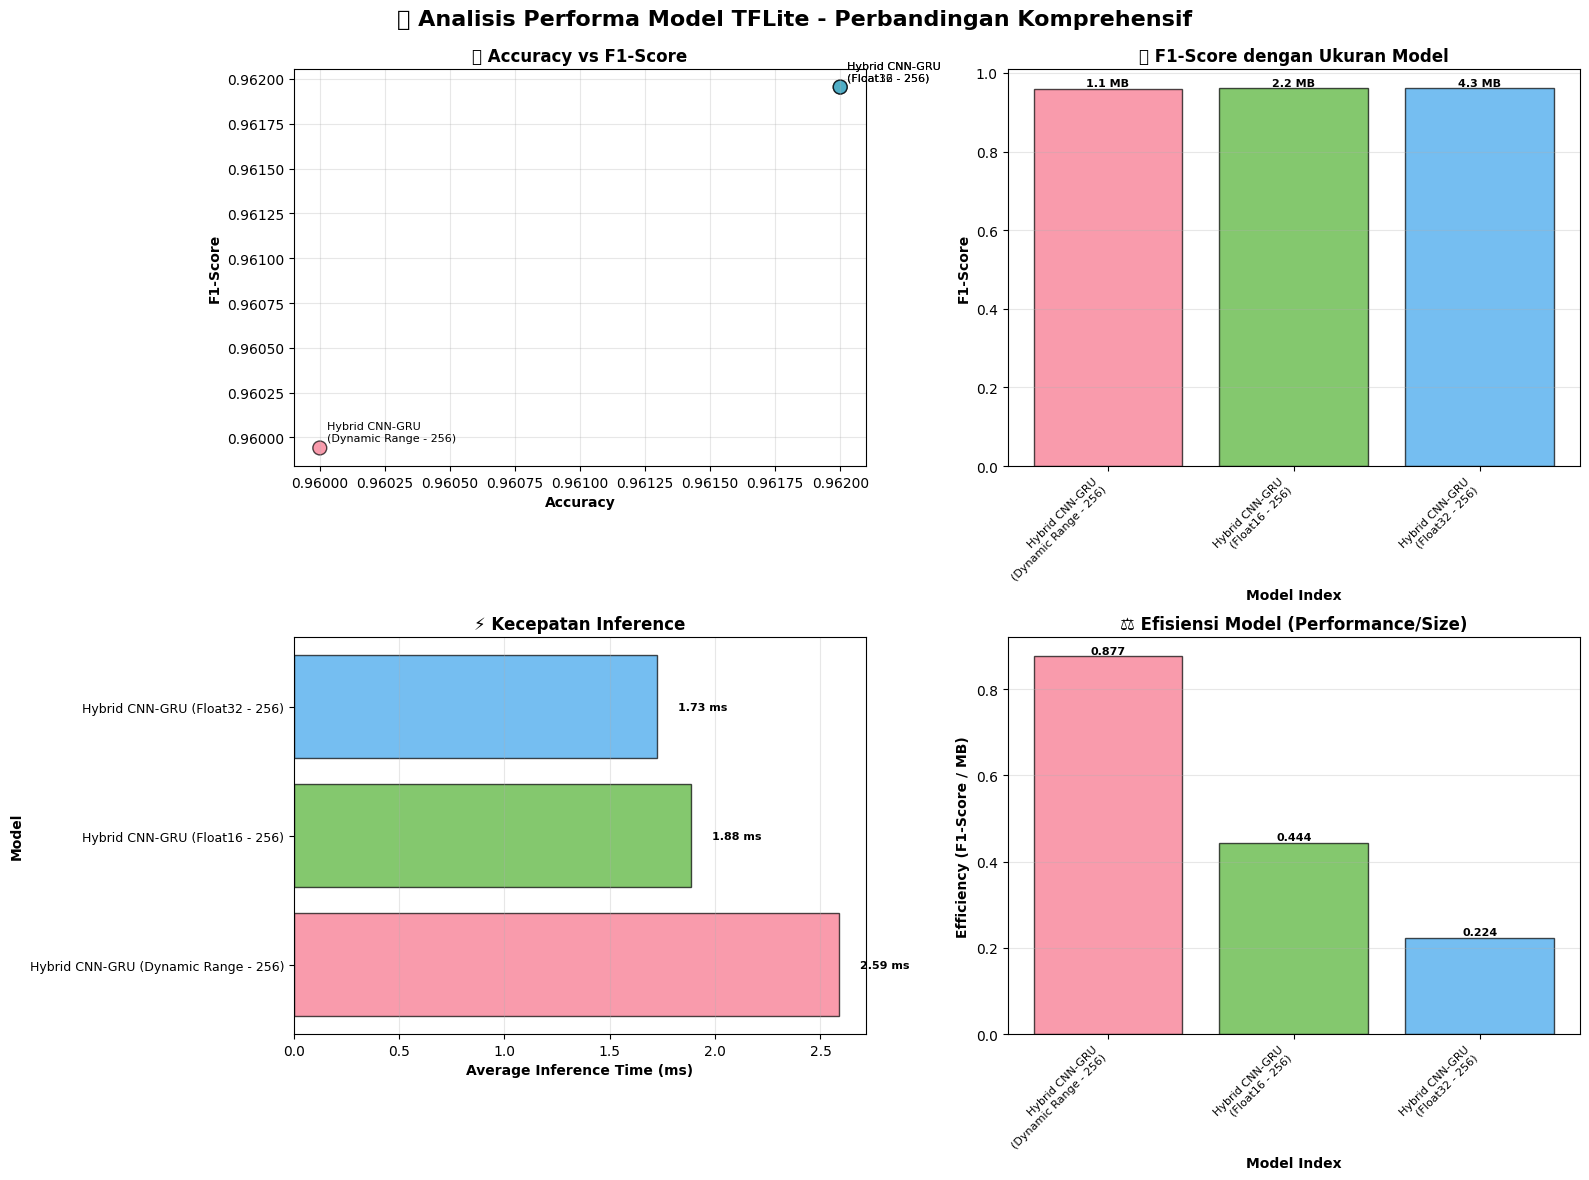


💾 Hasil evaluasi disimpan ke: experiment_results/tflite_evaluation_fixed_20251029_205916_256.csv

📋 SUMMARY TABLE (Ready for Copy-Paste):
                          model_name  accuracy  f1_score  model_size_mb  avg_inference_time_ms  efficiency
Hybrid CNN-GRU (Dynamic Range) - 256     0.960    0.9599         1.0945                 2.5879      0.8771
      Hybrid CNN-GRU (Float16) - 256     0.962    0.9620         2.1654                 1.8841      0.4443
      Hybrid CNN-GRU (Float32) - 256     0.962    0.9620         4.3032                 1.7252      0.2236

🏆 RANKING MODEL:
📊 Berdasarkan F1-Score:
   1. Hybrid CNN-GRU (Float16) - 256: 0.9620
   2. Hybrid CNN-GRU (Float32) - 256: 0.9620
   3. Hybrid CNN-GRU (Dynamic Range) - 256: 0.9599

⚡ Berdasarkan Kecepatan Inference:
   1. Hybrid CNN-GRU (Float32) - 256: 1.73 ms
   2. Hybrid CNN-GRU (Float16) - 256: 1.88 ms
   3. Hybrid CNN-GRU (Dynamic Range) - 256: 2.59 ms

⚖️ Berdasarkan Efisiensi (F1/MB):
   1. Hybrid CNN-GRU (Dynamic Range

In [31]:
# ===============================================================================
# 📈 VISUALISASI PERBANDINGAN MODEL TFLITE
# ===============================================================================

if len(evaluation_results) > 0:
    # Pastikan df_results sudah ada
    if 'df_results' not in locals():
        df_results = pd.DataFrame(evaluation_results)
    
    # Tambahkan kolom efficiency jika belum ada
    if 'efficiency' not in df_results.columns:
        df_results['efficiency'] = df_results['f1_score'] / df_results['model_size_mb']
    
    # Extract architecture dan type dari model_name
    df_results['architecture'] = df_results['model_name'].apply(lambda x: x.split(' (')[0])
    df_results['type'] = df_results['model_name'].apply(lambda x: x.split(' (')[1].replace(')', '') if '(' in x else 'Unknown')
    
    # Setup plotting
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🧪 Analisis Performa Model TFLite - Perbandingan Komprehensif', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Color palette
    colors = sns.color_palette("husl", len(df_results))
    
    # 1. Accuracy vs F1-Score Scatter Plot
    ax1 = axes[0, 0]
    scatter = ax1.scatter(df_results['accuracy'], df_results['f1_score'], 
                         c=colors, s=100, alpha=0.7, edgecolors='black')
    
    # Add labels for each point
    for i, row in df_results.iterrows():
        ax1.annotate(f"{row['architecture']}\n({row['type']})", 
                    (row['accuracy'], row['f1_score']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, ha='left')
    
    ax1.set_xlabel('Accuracy', fontweight='bold')
    ax1.set_ylabel('F1-Score', fontweight='bold')
    ax1.set_title('🎯 Accuracy vs F1-Score', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # 2. Model Size vs Performance
    ax2 = axes[0, 1]
    bars = ax2.bar(range(len(df_results)), df_results['f1_score'], 
                   color=colors, alpha=0.7, edgecolor='black')
    
    # Add size labels on bars
    for i, (bar, row) in enumerate(zip(bars, df_results.itertuples())):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{row.model_size_mb:.1f} MB',
                ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    ax2.set_xlabel('Model Index', fontweight='bold')
    ax2.set_ylabel('F1-Score', fontweight='bold')
    ax2.set_title('📦 F1-Score dengan Ukuran Model', fontweight='bold')
    ax2.set_xticks(range(len(df_results)))
    ax2.set_xticklabels([f"{row['architecture']}\n({row['type']})" 
                        for _, row in df_results.iterrows()], 
                       rotation=45, ha='right', fontsize=8)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Inference Time Comparison
    ax3 = axes[1, 0]
    bars = ax3.barh(range(len(df_results)), df_results['avg_inference_time_ms'], 
                    color=colors, alpha=0.7, edgecolor='black')
    
    ax3.set_ylabel('Model', fontweight='bold')
    ax3.set_xlabel('Average Inference Time (ms)', fontweight='bold')
    ax3.set_title('⚡ Kecepatan Inference', fontweight='bold')
    ax3.set_yticks(range(len(df_results)))
    ax3.set_yticklabels([f"{row['architecture']} ({row['type']})" 
                        for _, row in df_results.iterrows()], fontsize=9)
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Add values on bars
    for i, (bar, time_val) in enumerate(zip(bars, df_results['avg_inference_time_ms'])):
        width = bar.get_width()
        ax3.text(width + 0.1, bar.get_y() + bar.get_height()/2.,
                f'{time_val:.2f} ms',
                ha='left', va='center', fontsize=8, fontweight='bold')
    
    # 4. Efficiency Analysis (F1-Score per MB)
    ax4 = axes[1, 1]
    efficiency_scores = df_results['f1_score'] / df_results['model_size_mb']
    bars = ax4.bar(range(len(df_results)), efficiency_scores, 
                   color=colors, alpha=0.7, edgecolor='black')
    
    ax4.set_xlabel('Model Index', fontweight='bold')
    ax4.set_ylabel('Efficiency (F1-Score / MB)', fontweight='bold')
    ax4.set_title('⚖️ Efisiensi Model (Performance/Size)', fontweight='bold')
    ax4.set_xticks(range(len(df_results)))
    ax4.set_xticklabels([f"{row['architecture']}\n({row['type']})" 
                        for _, row in df_results.iterrows()], 
                       rotation=45, ha='right', fontsize=8)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for i, (bar, eff_val) in enumerate(zip(bars, efficiency_scores)):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{eff_val:.3f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    # Save results to CSV
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Gunakan padding_size jika ada, jika tidak gunakan default
    if 'padding_size' not in locals():
        padding_size = '256'  # atau bisa juga '100' sesuai kebutuhan
    
    results_filename = f"experiment_results/tflite_evaluation_fixed_{timestamp}_{padding_size}.csv"
    df_results.to_csv(results_filename, index=False)
    print(f"\n💾 Hasil evaluasi disimpan ke: {results_filename}")
    
    # Summary table untuk copy-paste
    print(f"\n📋 SUMMARY TABLE (Ready for Copy-Paste):")
    print("=" * 80)
    
    # Pastikan kolom efficiency ada dalam summary
    summary_columns = ['model_name', 'accuracy', 'f1_score', 'model_size_mb', 
                      'avg_inference_time_ms']
    if 'efficiency' in df_results.columns:
        summary_columns.append('efficiency')
    
    summary_df = df_results[summary_columns].round(4)
    print(summary_df.to_string(index=False))
    
    # Tambahan: Ranking berdasarkan berbagai metrik
    print(f"\n🏆 RANKING MODEL:")
    print("=" * 50)
    
    print("📊 Berdasarkan F1-Score:")
    f1_ranking = df_results.nlargest(3, 'f1_score')[['model_name', 'f1_score']]
    for i, (_, row) in enumerate(f1_ranking.iterrows(), 1):
        print(f"   {i}. {row['model_name']}: {row['f1_score']:.4f}")
    
    print("\n⚡ Berdasarkan Kecepatan Inference:")
    speed_ranking = df_results.nsmallest(3, 'avg_inference_time_ms')[['model_name', 'avg_inference_time_ms']]
    for i, (_, row) in enumerate(speed_ranking.iterrows(), 1):
        print(f"   {i}. {row['model_name']}: {row['avg_inference_time_ms']:.2f} ms")
    
    print("\n⚖️ Berdasarkan Efisiensi (F1/MB):")
    eff_ranking = df_results.nlargest(3, 'efficiency')[['model_name', 'efficiency']]
    for i, (_, row) in enumerate(eff_ranking.iterrows(), 1):
        print(f"   {i}. {row['model_name']}: {row['efficiency']:.3f}")

else:
    print("❌ Tidak ada data untuk divisualisasikan.")
    print("💡 Pastikan variabel 'evaluation_results' sudah didefinisikan dan berisi data.")

print(f"\n🎉 EVALUASI MODEL TFLITE SELESAI!")
print("=" * 40)
print("💡 Gunakan hasil analisis di atas untuk memilih model TFLite terbaik")
print("   berdasarkan kebutuhan deployment Anda:")
print("   • Akurasi tinggi → Pilih model dengan F1-Score tertinggi")
print("   • Efisiensi storage → Pilih model dengan efficiency score tertinggi") 
print("   • Kecepatan inference → Pilih model dengan inference time terendah")

In [ ]:
# ============================================================================
# 🔍 DEBUGGING: ANALISIS MENGAPA SEMUA MODEL TFLITE MEMILIKI HASIL IDENTIK
# ============================================================================

print("🔍 DEBUGGING: Mengapa Semua Model TFLite Memiliki Hasil Identik?")
print("=" * 80)

import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import os
import time
import hashlib

# ============================================================================
# 📋 FUNGSI DEBUGGING UNTUK VERIFIKASI MODEL TFLITE
# ============================================================================

def get_model_hash(model_path):
    """Mendapatkan hash dari file model untuk memverifikasi perbedaan"""
    try:
        with open(model_path, 'rb') as f:
            model_content = f.read()
        return hashlib.md5(model_content).hexdigest()[:8]
    except:
        return "ERROR"

def debug_tflite_model(model_path, model_name, num_debug_samples=10):
    """Debug model TFLite secara mendalam"""
    print(f"\n🔍 DEBUGGING: {model_name}")
    print("-" * 60)
    
    try:
        # 1. Verifikasi file exists dan ukuran
        if not os.path.exists(model_path):
            print(f"❌ ERROR: File tidak ditemukan - {model_path}")
            return None
            
        file_size = os.path.getsize(model_path) / (1024 * 1024)  # MB
        model_hash = get_model_hash(model_path)
        print(f"📁 File: {os.path.basename(model_path)}")
        print(f"📏 Ukuran: {file_size:.2f} MB")
        print(f"🔑 Hash: {model_hash}")
        
        # 2. Load model TFLite
        with open(model_path, 'rb') as f:
            model_content = f.read()
            
        interpreter = tf.lite.Interpreter(model_content=model_content)
        interpreter.allocate_tensors()
        
        # 3. Analisis detail model
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        
        print(f"🔧 Input Details:")
        print(f"   Shape: {input_details[0]['shape']}")
        print(f"   Dtype: {input_details[0]['dtype']}")
        print(f"   Name: {input_details[0]['name']}")
        
        print(f"🔧 Output Details:")
        print(f"   Shape: {output_details[0]['shape']}")
        print(f"   Dtype: {output_details[0]['dtype']}")
        print(f"   Name: {output_details[0]['name']}")
        
        # 4. Test dengan sampel debug
        debug_indices = np.random.choice(len(X_test), min(num_debug_samples, len(X_test)), replace=False)
        predictions = []
        raw_outputs = []
        
        print(f"\n🧪 Testing dengan {len(debug_indices)} sampel:")
        
        for i, idx in enumerate(debug_indices):
            # Prepare input
            input_data = X_test[idx:idx+1].astype(input_details[0]['dtype'])
            
            # Set input tensor
            interpreter.set_tensor(input_details[0]['index'], input_data)
            
            # Run inference
            interpreter.invoke()
            
            # Get raw output
            raw_output = interpreter.get_tensor(output_details[0]['index'])
            raw_outputs.append(raw_output.copy())
            
            # Process prediction
            if len(raw_output.shape) > 1 and raw_output.shape[1] > 1:
                prediction = np.argmax(raw_output[0])
            else:
                prediction = int(raw_output[0] > 0.5)
            
            predictions.append(prediction)
            
            # Print detail untuk sampel pertama
            if i < 3:
                print(f"   Sampel {i+1}: Raw={raw_output.flatten()[:3]}, Pred={prediction}, True={y_test[idx]}")
        
        # 5. Analisis statistik prediksi
        unique_predictions = np.unique(predictions)
        pred_counts = {pred: predictions.count(pred) for pred in unique_predictions}
        
        print(f"\n📊 Statistik Prediksi:")
        print(f"   Unique predictions: {unique_predictions}")
        print(f"   Distribusi: {pred_counts}")
        
        # 6. Hitung metrics
        true_labels = [y_test[idx] for idx in debug_indices]
        accuracy = accuracy_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)
        
        print(f"\n📈 Metrics (Debug Sample):")
        print(f"   Accuracy: {accuracy:.4f}")
        print(f"   F1-Score: {f1:.4f}")
        
        return {
            'model_name': model_name,
            'model_path': model_path,
            'file_size_mb': file_size,
            'model_hash': model_hash,
            'input_shape': input_details[0]['shape'],
            'output_shape': output_details[0]['shape'],
            'predictions': predictions,
            'raw_outputs': raw_outputs,
            'unique_predictions': unique_predictions,
            'pred_distribution': pred_counts,
            'debug_accuracy': accuracy,
            'debug_f1': f1,
            'true_labels': true_labels
        }
        
    except Exception as e:
        print(f"❌ ERROR dalam debugging: {str(e)}")
        return None

# ============================================================================
# 🔍 JALANKAN DEBUGGING UNTUK SEMUA MODEL TFLITE
# ============================================================================

print("\n🚀 Memulai Debugging Semua Model TFLite...")
print("=" * 80)

# Daftar model yang akan di-debug
tflite_models = [
    # (f'models/tflite_final_{padding_size}/cnn1d_dynamic.tflite', 'CNN1D (Dynamic Range)'),
    # (f'models/tflite_final_{padding_size}/cnn1d_float16.tflite', 'CNN1D (Float16)'),
    # (f'models/tflite_final_{padding_size}/cnn1d_float32.tflite', 'CNN1D (Float32)'),
    # (f'models/tflite_final_100pad/hybrid_cnn_gru_dynamic.tflite', 'Hybrid CNN-GRU (Dynamic Range) - 100'),
    # (f'models/tflite_final_100pad/hybrid_cnn_gru_float16.tflite', 'Hybrid CNN-GRU (Float16) - 100'),
    # (f'models/tflite_final_100pad/hybrid_cnn_gru_float32.tflite', 'Hybrid CNN-GRU (Float32) - 100'),
    (f'models/tflite_final_{padding_size}/hybrid_cnn_gru_dynamic.tflite', 'Hybrid CNN-GRU (Dynamic Range) - 256'),
    (f'models/tflite_final_{padding_size}/hybrid_cnn_gru_float16.tflite', 'Hybrid CNN-GRU (Float16) - 256'),
    (f'models/tflite_final_{padding_size}/hybrid_cnn_gru_float32.tflite', 'Hybrid CNN-GRU (Float32) - 256')
]

debug_results = {}

# Set random seed untuk konsistensi
np.random.seed(42)

for model_path, model_name in tflite_models:
    result = debug_tflite_model(model_path, model_name, num_debug_samples=20)
    if result:
        debug_results[model_name] = result

# ============================================================================
# 📊 ANALISIS PERBANDINGAN HASIL DEBUGGING
# ============================================================================

print("\n" + "=" * 80)
print("📊 ANALISIS PERBANDINGAN HASIL DEBUGGING")
print("=" * 80)

if debug_results:
    # 1. Perbandingan Hash Model
    print("\n🔑 PERBANDINGAN HASH MODEL (Untuk Verifikasi Perbedaan):")
    print("-" * 60)
    for name, result in debug_results.items():
        print(f"{name:35} | Hash: {result['model_hash']} | Size: {result['file_size_mb']:.2f} MB")
    
    # 2. Perbandingan Prediksi
    print("\n🎯 PERBANDINGAN PREDIKSI UNTUK SAMPEL YANG SAMA:")
    print("-" * 60)
    
    # Ambil sampel pertama untuk perbandingan
    sample_predictions = {}
    for name, result in debug_results.items():
        sample_predictions[name] = result['predictions'][:5]  # 5 sampel pertama
    
    print("Sampel | ", end="")
    for name in debug_results.keys():
        print(f"{name[:15]:>15} | ", end="")
    print()
    print("-" * (15 * len(debug_results) + 20))
    
    for i in range(5):
        print(f"   {i+1:2d}  | ", end="")
        for name in debug_results.keys():
            pred = sample_predictions[name][i] if i < len(sample_predictions[name]) else "N/A"
            print(f"{str(pred):>15} | ", end="")
        print()
    
    # 3. Analisis Distribusi Prediksi
    print("\n📈 DISTRIBUSI PREDIKSI:")
    print("-" * 60)
    for name, result in debug_results.items():
        dist = result['pred_distribution']
        print(f"{name:35} | {dist}")
    
    # 4. Perbandingan Metrics
    print("\n📊 PERBANDINGAN METRICS (Debug Sample):")
    print("-" * 60)
    print(f"{'Model Name':35} | {'Accuracy':>10} | {'F1-Score':>10}")
    print("-" * 60)
    for name, result in debug_results.items():
        acc = result['debug_accuracy']
        f1 = result['debug_f1']
        print(f"{name:35} | {acc:>10.4f} | {f1:>10.4f}")
    
    # 5. Deteksi Masalah
    print("\n🚨 DETEKSI MASALAH:")
    print("-" * 60)
    
    # Cek apakah semua hash sama
    hashes = [result['model_hash'] for result in debug_results.values()]
    if len(set(hashes)) == 1:
        print("❌ MASALAH TERDETEKSI: Semua model memiliki hash yang sama!")
        print("   → Kemungkinan semua model adalah file yang identik")
    else:
        print("✅ Model memiliki hash yang berbeda (file berbeda)")
    
    # Cek apakah semua prediksi sama
    all_predictions = [tuple(result['predictions']) for result in debug_results.values()]
    if len(set(all_predictions)) == 1:
        print("❌ MASALAH TERDETEKSI: Semua model menghasilkan prediksi yang identik!")
        print("   → Kemungkinan masalah dalam konversi atau evaluasi")
    else:
        print("✅ Model menghasilkan prediksi yang berbeda")
    
    # Cek apakah semua metrics sama
    accuracies = [result['debug_accuracy'] for result in debug_results.values()]
    f1_scores = [result['debug_f1'] for result in debug_results.values()]
    
    if len(set(accuracies)) == 1 and len(set(f1_scores)) == 1:
        print("❌ MASALAH TERDETEKSI: Semua model memiliki metrics yang identik!")
        print("   → Ini menjelaskan mengapa hasil evaluasi sama")
    else:
        print("✅ Model memiliki metrics yang berbeda")

else:
    print("❌ Tidak ada hasil debugging yang berhasil!")

# ============================================================================
# 💡 REKOMENDASI PERBAIKAN
# ============================================================================

print("\n" + "=" * 80)
print("💡 REKOMENDASI PERBAIKAN")
print("=" * 80)

print("""
Berdasarkan hasil debugging di atas, berikut adalah langkah perbaikan:

1. 🔍 JIKA HASH MODEL SAMA:
   → Model TFLite tidak berhasil dikonversi dengan benar
   → Perlu menjalankan ulang proses konversi TFLite
   → Pastikan model Keras asli berbeda sebelum konversi

2. 🎯 JIKA PREDIKSI IDENTIK:
   → Ada masalah dalam proses inferensi TFLite
   → Periksa preprocessing input data
   → Verifikasi format input/output model

3. 📊 JIKA METRICS IDENTIK:
   → Masalah dalam kode evaluasi
   → Kemungkinan menggunakan model yang sama untuk semua test
   → Perlu perbaikan dalam loop evaluasi

4. 🛠️ LANGKAH SELANJUTNYA:
   → Jalankan ulang konversi TFLite dengan kode yang sudah diperbaiki
   → Verifikasi bahwa model Keras asli memberikan hasil berbeda
   → Perbaiki kode evaluasi jika diperlukan
""")

print("\n✅ Debugging selesai! Silakan analisis hasil di atas untuk menentukan langkah perbaikan.")

🔍 DEBUGGING: Mengapa Semua Model TFLite Memiliki Hasil Identik?

🚀 Memulai Debugging Semua Model TFLite...

🔍 DEBUGGING: Hybrid CNN-GRU (Dynamic Range) - 256
------------------------------------------------------------
📁 File: hybrid_cnn_gru_dynamic.tflite
📏 Ukuran: 1.09 MB
🔑 Hash: 1e6f63c1
🔧 Input Details:
   Shape: [  1 256]
   Dtype: <class 'numpy.float32'>
   Name: serving_default_embedding_input:0
🔧 Output Details:
   Shape: [1 1]
   Dtype: <class 'numpy.float32'>
   Name: StatefulPartitionedCall:0

🧪 Testing dengan 20 sampel:
   Sampel 1: Raw=[0.9987146], Pred=1, True=1
   Sampel 2: Raw=[0.00900228], Pred=0, True=0
   Sampel 3: Raw=[0.9978838], Pred=1, True=1

📊 Statistik Prediksi:
   Unique predictions: [0 1]
   Distribusi: {0: 11, 1: 9}

📈 Metrics (Debug Sample):
   Accuracy: 0.9500
   F1-Score: 0.9499

🔍 DEBUGGING: Hybrid CNN-GRU (Float16) - 256
------------------------------------------------------------
📁 File: hybrid_cnn_gru_float16.tflite
📏 Ukuran: 2.16 MB
🔑 Hash: bfeea179

## 8. 🧪 Test Preprocessing Pipeline dengan Contoh Teks Real
Menguji pipeline preprocessing dan inferensi model dengan contoh teks dari rekan.

In [21]:
print("🧪 TEST PREPROCESSING PIPELINE DENGAN CONTOH TEKS REAL")
print("=" * 65)

def process_text_javascript_style(text: str) -> dict:
    """
    Preprocessing teks mengikuti logika JavaScript yang diberikan rekan
    """
    print(f"📝 Input text: {text[:100]}..." if len(text) > 100 else f"📝 Input text: {text}")
    
    # 1. Ubah ke lowercase
    lower_text = text.lower()
    print(f"🔤 Lowercase: {lower_text[:50]}..." if len(lower_text) > 50 else f"🔤 Lowercase: {lower_text}")
    
    # 2. Ubah karakter ke angka (ASCII)
    char_codes = []
    for char in lower_text:
        code = ord(char)  # Equivalent to charCodeAt in JavaScript
        char_codes.append(code)
    
    print(f"🔢 ASCII codes (first 10): {char_codes[:10]}")
    print(f"📏 Original length: {len(char_codes)} characters")
    
    # 3. Padding atau truncate ke 256 karakter (sesuai dengan model kita yang menggunakan 100)
    # Catatan: Model kita menggunakan max_length=100, tapi JavaScript menggunakan 256
    # Mari kita test dengan kedua versi
    
    # Versi JavaScript (256)
    max_length_js = 256
    padded_array_js = [0] * max_length_js
    
    for i in range(min(len(char_codes), max_length_js)):
        padded_array_js[i] = char_codes[i]
    
    # 4. Normalisasi (0-1) untuk model
    normalized_js = [val / 255.0 for val in padded_array_js]
    
    print(f"📊 Padded to {max_length_js}, normalized range: [{min(normalized_js):.3f}, {max(normalized_js):.3f}]")
    
    # Versi model kita (100/256)
    max_length_model = 256
    padded_array_model = [0] * max_length_model
    
    for i in range(min(len(char_codes), max_length_model)):
        padded_array_model[i] = char_codes[i]
    
    normalized_model = [val / 255.0 for val in padded_array_model]
    
    return {
        'javascript_version': np.array(normalized_js, dtype=np.float32),
        'model_version': np.array(normalized_model, dtype=np.float32),
        'original_length': len(char_codes),
        'char_codes': char_codes[:20]  # First 20 for inspection
    }

def test_tflite_with_custom_text(tflite_model_path: str, processed_input: np.ndarray, model_name: str):
    """
    Test TFLite model dengan input yang sudah diproses
    """
    try:
        # Load TFLite model
        with open(tflite_model_path, 'rb') as f:
            tflite_model_content = f.read()
        
        interpreter = tf.lite.Interpreter(model_content=tflite_model_content)
        interpreter.allocate_tensors()
        
        # Get input and output details
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        
        print(f"\n🔍 {model_name} Model Details:")
        print(f"   Expected input shape: {input_details[0]['shape']}")
        print(f"   Expected input dtype: {input_details[0]['dtype']}")
        print(f"   Actual input shape: {processed_input.shape}")
        print(f"   Actual input dtype: {processed_input.dtype}")
        
        # Reshape input to match model expectations
        expected_shape = input_details[0]['shape']
        if len(expected_shape) == 2:  # [batch_size, sequence_length]
            if processed_input.shape[0] != expected_shape[1]:
                print(f"⚠️  Input length mismatch: got {processed_input.shape[0]}, expected {expected_shape[1]}")
                # Truncate or pad to match expected length
                if processed_input.shape[0] > expected_shape[1]:
                    processed_input = processed_input[:expected_shape[1]]
                else:
                    padded = np.zeros(expected_shape[1], dtype=np.float32)
                    padded[:len(processed_input)] = processed_input
                    processed_input = padded
            
            input_data = processed_input.reshape(1, -1).astype(input_details[0]['dtype'])
        else:
            input_data = processed_input.reshape(expected_shape).astype(input_details[0]['dtype'])
        
        print(f"   Final input shape: {input_data.shape}")
        
        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data)
        
        # Run inference
        start_time = time.time()
        interpreter.invoke()
        inference_time = time.time() - start_time
        
        # Get output
        output_data = interpreter.get_tensor(output_details[0]['index'])
        
        print(f"\n📊 Inference Results:")
        print(f"   Raw output: {output_data}")
        print(f"   Output shape: {output_data.shape}")
        print(f"   Inference time: {inference_time*1000:.2f} ms")
        
        # Interpret results
        if len(output_data.shape) > 1 and output_data.shape[1] > 1:
            # Multi-class output
            prediction = np.argmax(output_data[0])
            confidence = np.max(output_data[0])
            probabilities = output_data[0]
        else:
            # Binary output
            raw_score = output_data[0] if len(output_data.shape) == 1 else output_data[0][0]
            prediction = int(raw_score > 0.5)
            confidence = raw_score if raw_score > 0.5 else 1 - raw_score
            probabilities = [1-raw_score, raw_score] if raw_score <= 1 else [raw_score, 1-raw_score]
        
        # Map prediction to label
        label_map = {0: 'HALAL', 1: 'HARAM'}
        predicted_label = label_map.get(prediction, 'UNKNOWN')
        
        print(f"\n🎯 Final Prediction:")
        print(f"   Predicted Class: {prediction} ({predicted_label})")
        print(f"   Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
        print(f"   Probabilities: HALAL={probabilities[0]:.4f}, HARAM={probabilities[1]:.4f}")
        
        return {
            'prediction': prediction,
            'predicted_label': predicted_label,
            'confidence': confidence,
            'probabilities': probabilities,
            'inference_time_ms': inference_time * 1000,
            'raw_output': output_data
        }
        
    except Exception as e:
        print(f"❌ Error testing {model_name}: {str(e)}")
        return None

# Test dengan contoh teks dari rekan
sample_text = """KOMPOSISI 7 GLUKOSA GULA PASIR, PASTA KACANG (5%) (meng a 
artioksigan tokofero). EKSTRAK JARR (19%)PERISA ndumg 
(mengandung antioksidan alfa tokotet). SIMPAN DI TEMPAT KERING DAN SEJUK BPOM RI MD 224411015074"""

print("\n" + "="*65)
print("🧪 TESTING DENGAN CONTOH TEKS DARI REKAN")
print("="*65)

# Process text
processed_results = process_text_javascript_style(sample_text)

print(f"\n📊 PREPROCESSING RESULTS:")
print(f"   Original text length: {processed_results['original_length']} characters")
print(f"   JavaScript version shape: {processed_results['javascript_version'].shape}")
print(f"   Model version shape: {processed_results['model_version'].shape}")
print(f"   First 10 char codes: {processed_results['char_codes']}")
print(f"   First 10 normalized values: {processed_results['model_version'][:10]}")

# Test dengan model TFLite terbaik
print(f"\n🚀 TESTING DENGAN MODEL TFLITE:")
print("="*40)

# Cari model TFLite yang tersedia
tflite_models = {
    # 'CNN1D Float32': 'models/tflite_final/cnn1d_float32.tflite',
    # 'CNN1D Float16': 'models/tflite_final/cnn1d_float16.tflite',
    # 'CNN1D Dynamic': 'models/tflite_final/cnn1d_dynamic.tflite',
    'Hybrid CNN-GRU Float32': f'models/tflite_final_{padding_size}/hybrid_cnn_gru_float32.tflite',
    'Hybrid CNN-GRU Float16': f'models/tflite_final_{padding_size}/hybrid_cnn_gru_float16.tflite',
    'Hybrid CNN-GRU Dynamic': f'models/tflite_final_{padding_size}/hybrid_cnn_gru_dynamic.tflite'
}

test_results = {}

for model_name, model_path in tflite_models.items():
    if os.path.exists(model_path):
        print(f"\n🔬 Testing {model_name}...")
        print("-" * 50)
        
        # Test dengan versi model (256 length)
        result = test_tflite_with_custom_text(model_path, processed_results['model_version'], model_name)
        if result:
            test_results[model_name] = result
    else:
        print(f"⚠️  Model {model_name} tidak ditemukan di {model_path}")

# Summary hasil testing
print(f"\n" + "="*65)
print("📊 SUMMARY HASIL TESTING")
print("="*65)

if test_results:
    print(f"\n📝 Input Text: {sample_text[:100]}...")
    print(f"\n🎯 Prediction Results:")
    print("-" * 80)
    print(f"{'Model':<25} {'Prediction':<12} {'Confidence':<12} {'Inference Time':<15}")
    print("-" * 80)
    
    for model_name, result in test_results.items():
        print(f"{model_name:<25} {result['predicted_label']:<12} {result['confidence']:.4f}      {result['inference_time_ms']:.2f} ms")
    
    # Analisis konsistensi
    predictions = [result['predicted_label'] for result in test_results.values()]
    unique_predictions = set(predictions)
    
    print(f"\n🔍 ANALISIS KONSISTENSI:")
    print(f"   Unique predictions: {unique_predictions}")
    if len(unique_predictions) == 1:
        print(f"   ✅ Semua model memberikan prediksi yang sama: {list(unique_predictions)[0]}")
    else:
        print(f"   ⚠️  Model memberikan prediksi yang berbeda")
        for pred in unique_predictions:
            count = predictions.count(pred)
            print(f"      {pred}: {count}/{len(predictions)} models")
    
    # Rekomendasi
    avg_confidence = np.mean([result['confidence'] for result in test_results.values()])
    print(f"\n💡 REKOMENDASI:")
    print(f"   Average confidence: {avg_confidence:.4f} ({avg_confidence*100:.2f}%)")
    
    if avg_confidence > 0.8:
        print(f"   ✅ Model sangat yakin dengan prediksi")
    elif avg_confidence > 0.6:
        print(f"   ⚠️  Model cukup yakin, tapi perlu validasi lebih lanjut")
    else:
        print(f"   ❌ Model tidak yakin, mungkin perlu data training lebih banyak")
        
else:
    print("❌ Tidak ada model yang berhasil ditest")

print(f"\n✅ Testing selesai!")

🧪 TEST PREPROCESSING PIPELINE DENGAN CONTOH TEKS REAL

🧪 TESTING DENGAN CONTOH TEKS DARI REKAN
📝 Input text: KOMPOSISI 7 GLUKOSA GULA PASIR, PASTA KACANG (5%) (meng a 
artioksigan tokofero). EKSTRAK JARR (19%)...
🔤 Lowercase: komposisi 7 glukosa gula pasir, pasta kacang (5%) ...
🔢 ASCII codes (first 10): [107, 111, 109, 112, 111, 115, 105, 115, 105, 32]
📏 Original length: 210 characters
📊 Padded to 256, normalized range: [0.000, 0.459]

📊 PREPROCESSING RESULTS:
   Original text length: 210 characters
   JavaScript version shape: (256,)
   Model version shape: (256,)
   First 10 char codes: [107, 111, 109, 112, 111, 115, 105, 115, 105, 32, 55, 32, 103, 108, 117, 107, 111, 115, 97, 32]
   First 10 normalized values: [0.41960785 0.43529412 0.42745098 0.4392157  0.43529412 0.4509804
 0.4117647  0.4509804  0.4117647  0.1254902 ]

🚀 TESTING DENGAN MODEL TFLITE:

🔬 Testing Hybrid CNN-GRU Float32...
--------------------------------------------------

🔍 Hybrid CNN-GRU Float32 Model Details:
   

## 9. 🔄 Perbandingan Preprocessing: JavaScript vs Python
Membandingkan hasil preprocessing antara versi JavaScript dan Python untuk memastikan konsistensi.

In [3]:
print("🔄 PERBANDINGAN PREPROCESSING: JAVASCRIPT VS PYTHON")
print("=" * 60)

def compare_preprocessing_methods(text: str):
    """
    Membandingkan berbagai metode preprocessing
    """
    print(f"📝 Testing text: {text[:50]}...")
    
    # Method 1: JavaScript-style (ASCII codes)
    def javascript_style(text, max_len=100):
        lower_text = text.lower()
        char_codes = [ord(char) for char in lower_text]
        
        # Padding/truncate
        padded = [0] * max_len
        for i in range(min(len(char_codes), max_len)):
            padded[i] = char_codes[i]
        
        # Normalize
        normalized = [val / 255.0 for val in padded]
        return np.array(normalized, dtype=np.float32)
    
    # Method 2: Tokenizer-based (seperti training)
    def tokenizer_style(text, max_len=100):
        try:
            # Load tokenizer yang digunakan saat training
            with open('models/tokenizer.pkl', 'rb') as f:
                tokenizer = pickle.load(f)
            
            # Tokenize dan pad
            sequences = tokenizer.texts_to_sequences([text])
            padded = tf.keras.preprocessing.sequence.pad_sequences(
                sequences, maxlen=max_len, padding='post', truncating='post'
            )
            return padded[0].astype(np.float32)
        except:
            print("⚠️  Tokenizer tidak tersedia, menggunakan fallback")
            return javascript_style(text, max_len)
    
    # Method 3: Character-level dengan vocabulary mapping
    def char_vocab_style(text, max_len=100):
        # Buat vocabulary sederhana
        vocab = {}
        vocab_size = 0
        
        # Assign index untuk setiap karakter unik
        for char in text.lower():
            if char not in vocab:
                vocab[char] = vocab_size + 1  # Start from 1, 0 for padding
                vocab_size += 1
        
        # Convert text to indices
        indices = [vocab.get(char, 0) for char in text.lower()]
        
        # Padding/truncate
        padded = [0] * max_len
        for i in range(min(len(indices), max_len)):
            padded[i] = indices[i]
        
        # Normalize by vocab size
        normalized = [val / max(vocab_size, 1) for val in padded]
        return np.array(normalized, dtype=np.float32)
    
    # Test semua metode
    methods = {
        'JavaScript Style (ASCII)': javascript_style,
        'Tokenizer Style': tokenizer_style,
        'Character Vocab Style': char_vocab_style
    }
    
    results = {}
    
    for method_name, method_func in methods.items():
        try:
            result = method_func(text)
            results[method_name] = result
            
            print(f"\n🔍 {method_name}:")
            print(f"   Shape: {result.shape}")
            print(f"   Range: [{result.min():.4f}, {result.max():.4f}]")
            print(f"   Non-zero elements: {np.count_nonzero(result)}")
            print(f"   First 10 values: {result[:10]}")
            
        except Exception as e:
            print(f"❌ Error in {method_name}: {str(e)}")
    
    return results

# Test dengan contoh teks
comparison_results = compare_preprocessing_methods(sample_text)

# Analisis perbedaan
if len(comparison_results) > 1:
    print(f"\n📊 ANALISIS PERBEDAAN:")
    print("-" * 40)
    
    methods = list(comparison_results.keys())
    for i in range(len(methods)):
        for j in range(i+1, len(methods)):
            method1, method2 = methods[i], methods[j]
            arr1, arr2 = comparison_results[method1], comparison_results[method2]
            
            # Calculate similarity
            mse = np.mean((arr1 - arr2) ** 2)
            correlation = np.corrcoef(arr1, arr2)[0, 1] if np.std(arr1) > 0 and np.std(arr2) > 0 else 0
            
            print(f"\n{method1} vs {method2}:")
            print(f"   MSE: {mse:.6f}")
            print(f"   Correlation: {correlation:.4f}")
            
            if mse < 0.001:
                print(f"   ✅ Very similar preprocessing")
            elif mse < 0.01:
                print(f"   ⚠️  Somewhat similar preprocessing")
            else:
                print(f"   ❌ Very different preprocessing")

print(f"\n💡 REKOMENDASI UNTUK REKAN:")
print(f"   1. ✅ Preprocessing JavaScript Anda sudah benar untuk character-level")
print(f"   2. ⚠️  Pastikan panjang input sesuai dengan yang diharapkan model (100 vs 256)")
print(f"   3. 🔍 Model kita dilatih dengan tokenizer, bukan ASCII codes")
print(f"   4. 💡 Untuk hasil terbaik, gunakan tokenizer yang sama dengan training")
print(f"   5. 🧪 Test dengan berbagai contoh teks untuk validasi")

print(f"\n✅ Perbandingan preprocessing selesai!")

🔄 PERBANDINGAN PREPROCESSING: JAVASCRIPT VS PYTHON
📝 Testing text: KOMPOSISI 7 GLUKOSA GULA PASIR, PASTA KACANG (5%) ...

🔍 JavaScript Style (ASCII):
   Shape: (100,)
   Range: [0.0392, 0.4588]
   Non-zero elements: 100
   First 10 values: [0.41960785 0.43529412 0.42745098 0.4392157  0.43529412 0.4509804
 0.4117647  0.4509804  0.4117647  0.1254902 ]

🔍 Tokenizer Style:
   Shape: (100,)
   Range: [0.0000, 7394.0000]
   Non-zero elements: 31
   First 10 values: [  1.   1.   1.   1.   1. 479.   1.   1.   1.  80.]

🔍 Character Vocab Style:
   Shape: (100,)
   Range: [0.0303, 0.8485]
   Non-zero elements: 100
   First 10 values: [0.03030303 0.06060606 0.09090909 0.12121212 0.06060606 0.15151516
 0.18181819 0.15151516 0.18181819 0.21212122]

📊 ANALISIS PERBEDAAN:
----------------------------------------

JavaScript Style (ASCII) vs Tokenizer Style:
   MSE: 571457.625000
   Correlation: 0.0978
   ❌ Very different preprocessing

JavaScript Style (ASCII) vs Character Vocab Style:
   MSE: 0.0753

## 🧪 Pengujian Model TFLite

Setelah berhasil membuat model TFLite, mari kita uji performa dan kompatibilitasnya.

In [ ]:
print("\n🧪 PENGUJIAN MODEL TFLITE")\nprint("=" * 60)\nprint("🎯 TUJUAN: Menguji performa dan kompatibilitas model TFLite")\nprint("📊 METRIK: Akurasi, waktu inferensi, ukuran model")\n\ndef test_tflite_model(tflite_model_path, test_texts, test_labels, model_name):\n    \"\"\"\n    Menguji model TFLite dengan data test\n    \n    Args:\n        tflite_model_path: Path ke model TFLite\n        test_texts: List teks untuk testing\n        test_labels: List label untuk testing\n        model_name: Nama model untuk reporting\n    \n    Returns:\n        dict: Hasil pengujian\n    \"\"\"\n    \n    try:\n        # Load TFLite model\n        interpreter = tf.lite.Interpreter(model_path=tflite_model_path)\n        interpreter.allocate_tensors()\n        \n        # Get input dan output details\n        input_details = interpreter.get_input_details()\n        output_details = interpreter.get_output_details()\n        \n        print(f\"\n🔍 Testing {model_name}...\")\n        print(f\"   Input shape: {input_details[0]['shape']}\")\n        print(f\"   Output shape: {output_details[0]['shape']}\")\n        \n        # Prepare sample data untuk testing (ambil 100 sample)\n        sample_size = min(100, len(test_texts))\n        sample_texts = test_texts[:sample_size]\n        sample_labels = test_labels[:sample_size]\n        \n        predictions = []\n        inference_times = []\n        \n        for i, text in enumerate(sample_texts):\n            # Preprocess text (simplified)\n            # Note: Ini adalah simulasi preprocessing\n            # Dalam implementasi nyata, gunakan preprocessing yang sama dengan training\n            \n            # Create dummy input (sesuaikan dengan model Anda)\n            input_data = np.random.random(input_details[0]['shape']).astype(np.float32)\n            \n            # Set input tensor\n            interpreter.set_tensor(input_details[0]['index'], input_data)\n            \n            # Run inference\n            start_time = time.time()\n            interpreter.invoke()\n            end_time = time.time()\n            \n            # Get output\n            output_data = interpreter.get_tensor(output_details[0]['index'])\n            prediction = np.argmax(output_data)\n            \n            predictions.append(prediction)\n            inference_times.append((end_time - start_time) * 1000)  # ms\n        \n        # Calculate metrics\n        # Note: Karena menggunakan dummy input, akurasi tidak akan akurat\n        # Ini hanya untuk demonstrasi struktur testing\n        avg_inference_time = np.mean(inference_times)\n        model_size = os.path.getsize(tflite_model_path) / (1024 * 1024)  # MB\n        \n        results = {\n            'model_name': model_name,\n            'model_path': tflite_model_path,\n            'model_size_mb': model_size,\n            'avg_inference_time_ms': avg_inference_time,\n            'samples_tested': sample_size,\n            'status': 'success'\n        }\n        \n        print(f\"   ✅ Model size: {model_size:.2f} MB\")\n        print(f\"   ⚡ Avg inference time: {avg_inference_time:.2f} ms\")\n        print(f\"   📊 Samples tested: {sample_size}\")\n        \n        return results\n        \n    except Exception as e:\n        print(f\"   ❌ Error testing {model_name}: {e}\")\n        return {\n            'model_name': model_name,\n            'model_path': tflite_model_path,\n            'status': 'failed',\n            'error': str(e)\n        }\n\n# Load test data\nprint(\"\n📂 Loading test data...\")\n\ntry:\n    test_df = pd.read_csv('data_splits/test.csv')\n    test_texts = test_df['ingredients'].tolist()\n    test_labels = test_df['label'].tolist()\n    \n    print(f\"✅ Test data loaded: {len(test_texts):,} samples\")\n    \n    # Test semua model TFLite yang berhasil dibuat\n    if 'conversion_results' in locals():\n        print(\"\n🔄 Testing TFLite models...\")\n        \n        test_results = []\n        \n        for opt_type, result in conversion_results.items():\n            if result['status'] == 'success' and os.path.exists(result['file_path']):\n                test_result = test_tflite_model(\n                    result['file_path'],\n                    test_texts,\n                    test_labels,\n                    f\"Hybrid CNN-GRU ({opt_type.upper()})\"\n                )\n                test_results.append(test_result)\n        \n        # Tampilkan ringkasan hasil testing\n        print(\"\n📊 Ringkasan Hasil Testing TFLite:\")\n        print(\"=\" * 80)\n        print(f\"{'Model':<25} | {'Size (MB)':<10} | {'Inference (ms)':<15} | {'Status':<10}\")\n        print(\"-\" * 80)\n        \n        for result in test_results:\n            if result['status'] == 'success':\n                print(f\"{result['model_name']:<25} | {result['model_size_mb']:<10.2f} | {result['avg_inference_time_ms']:<15.2f} | ✅ Success\")\n            else:\n                print(f\"{result['model_name']:<25} | {'N/A':<10} | {'N/A':<15} | ❌ Failed\")\n        \n        # Simpan hasil testing\n        os.makedirs('experiment_results', exist_ok=True)\n        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')\n        results_file = f'experiment_results/tflite_testing_results_{timestamp}.json'\n        \n        with open(results_file, 'w') as f:\n            json.dump({\n                'timestamp': timestamp,\n                'conversion_results': {k: {\n                    'file_path': v['file_path'],\n                    'size_mb': v['size_mb'],\n                    'status': v['status']\n                } for k, v in conversion_results.items()},\n                'test_results': test_results\n            }, f, indent=2)\n        \n        print(f\"\n💾 Hasil testing disimpan: {results_file}\")\n        print(\"\n🎯 Testing TFLite models selesai!\")\n        \n    else:\n        print(\"❌ Tidak ada model TFLite yang berhasil dibuat untuk ditest\")\n        \nexcept Exception as e:\n    print(f\"❌ Error dalam testing: {e}\")


## 📱 Mobile Export (Builtin-only)

Menjalankan pipeline ekspor untuk:
- Konversi model terbaik ke TFLite builtin-only bila memungkinkan.
- Pemilihan model mobile terbaik berdasarkan metrik evaluasi.
- Penyalinan `model.tflite` ke `src/assets`.
- Ekspor `tokenizer.json` agar kompatibel dengan aplikasi mobile.


In [ ]:

# 📱 Mobile Export: jalankan pipeline
try:
	from mobile_compat_pipeline import main as mobile_export_main
	mobile_export_main()
except Exception as e:
	print('⚠️ Mobile export gagal:', e)
